# PUBG Survival Time Prediction

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("./Data/PUBG_Player_Statistics.csv")
df.head()

`player_name`과 `tracker_id`는 지우고 시작한다.

In [ ]:
df.drop(['player_name', 'tracker_id'], axis=1, inplace=True)

솔로와 듀오, 스쿼드에서 플레이어의 다양한 스탯을 이용하여 스쿼드 게임에서의 생존 시간을 예측해본다. 솔로나 듀오, 스쿼드를 편향적으로 플레이하는 유저들을 제거하기 위해서 다음의 쿼리를 한다.

In [ ]:
pubg = df.query('solo_RoundsPlayed>=20').query('duo_RoundsPlayed>=20').query('squad_RoundsPlayed>=20')

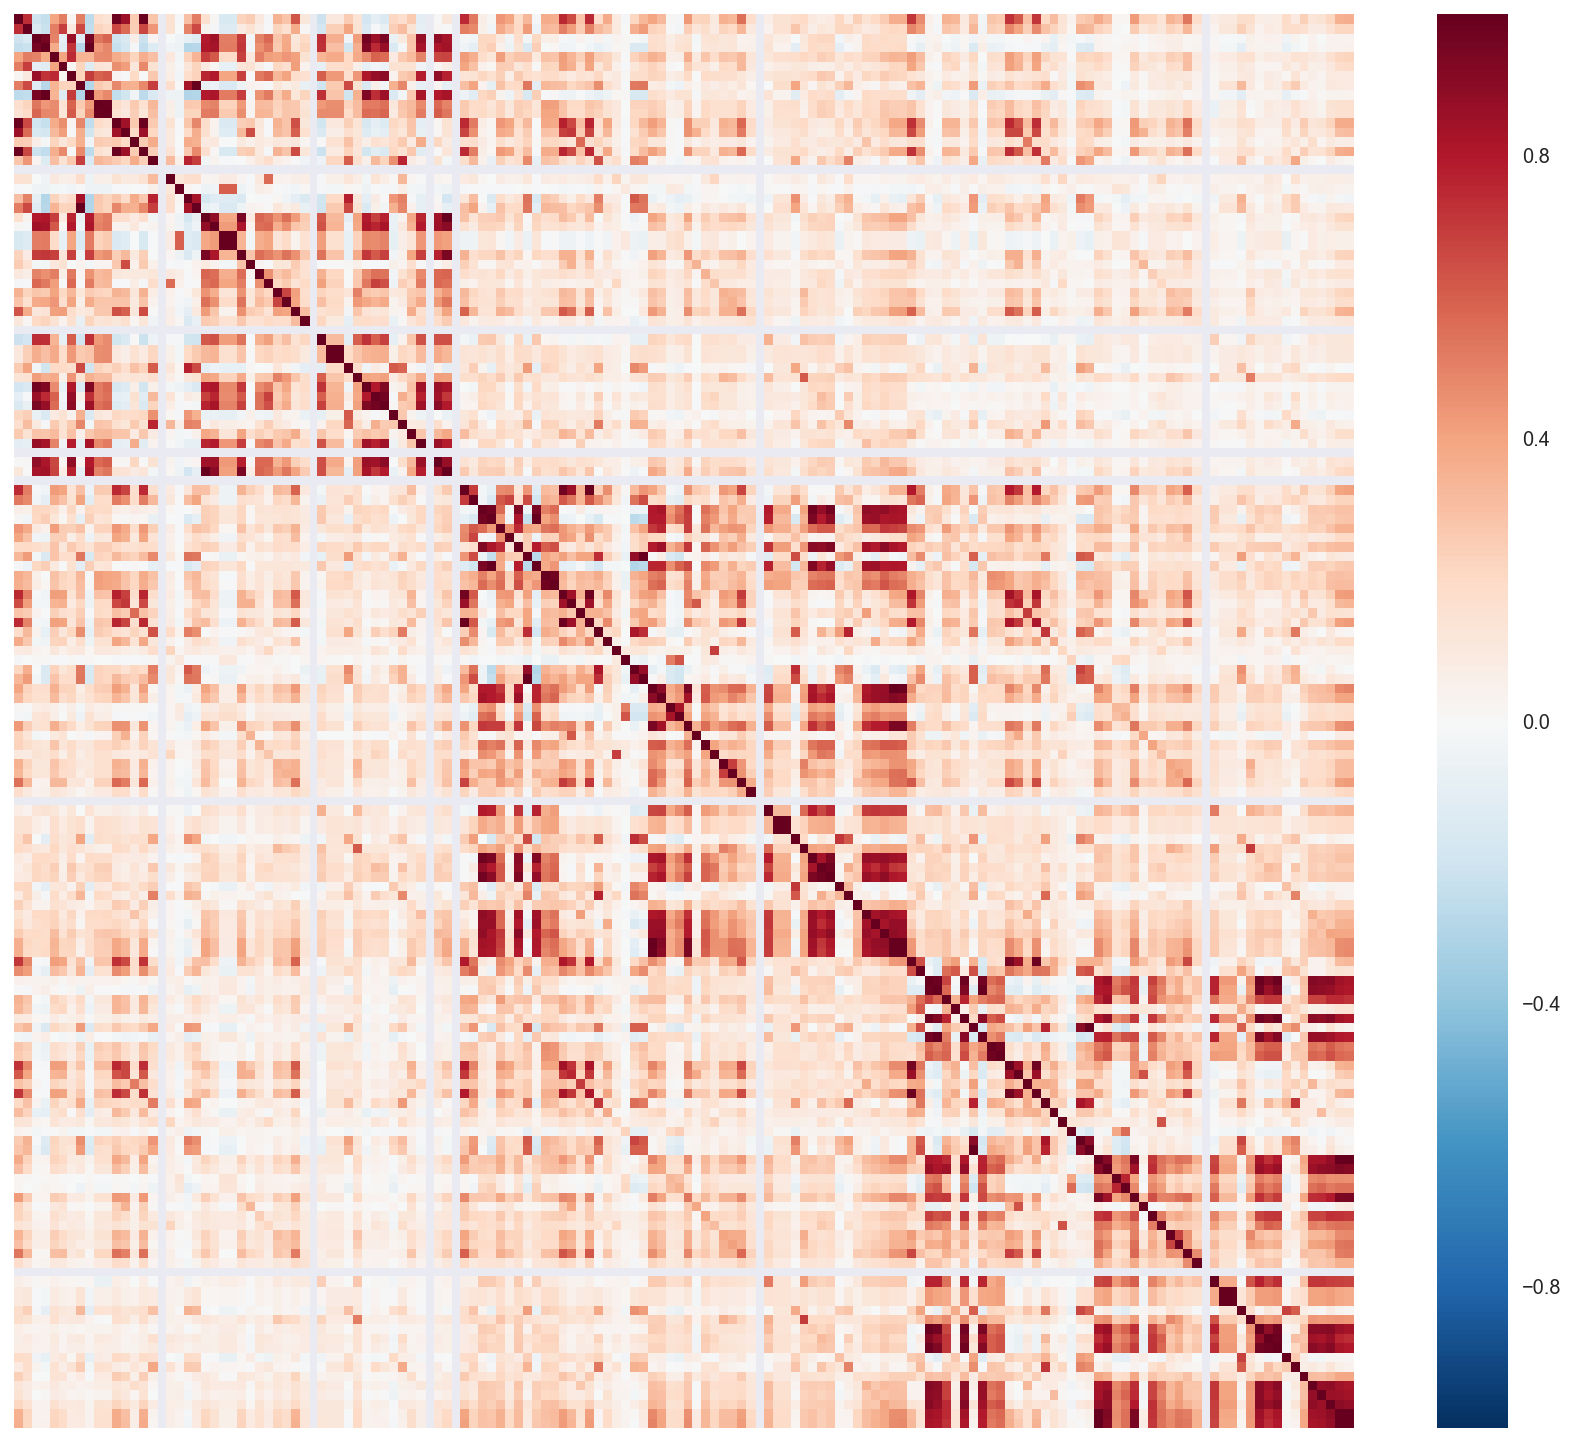

In [8]:
corr = pubg.corr()
plt.figure(figsize=(15,13))
sns.heatmap(corr, xticklabels=False, yticklabels=False)

변수들의 상관관계를 본 결과, 각 게임 타입마다 높은 상관관계를 보였으며, 서로 다른 게임 타입에 대해서는 낮은 상관관계를 보였다. 하지만 각 변수 특성의 패턴은 유지되는 것으로 보인다. 본 분석에서는 스쿼드 생존시간을 예측하기 때문에 스쿼드의 몇몇 변수의 사용을 조심해야할 것으로 보인다. 특히 **데이터 누출(Data leakage)** 을 방지하기 위해서 예측에 사용할 변수 선택에 신중을 기해야 한다.

누적 데이터를 포함하는 변수는 제거하거나 게임 수로 나눠 피쳐 엔지니어링을 수행해야 한다. 존재하는 변수들의 이름은 다음과 같다.

In [9]:
pubg.columns.tolist()

['solo_KillDeathRatio',
 'solo_WinRatio',
 'solo_TimeSurvived',
 'solo_RoundsPlayed',
 'solo_Wins',
 'solo_WinTop10Ratio',
 'solo_Top10s',
 'solo_Top10Ratio',
 'solo_Losses',
 'solo_Rating',
 'solo_BestRating',
 'solo_DamagePg',
 'solo_HeadshotKillsPg',
 'solo_HealsPg',
 'solo_KillsPg',
 'solo_MoveDistancePg',
 'solo_RevivesPg',
 'solo_RoadKillsPg',
 'solo_TeamKillsPg',
 'solo_TimeSurvivedPg',
 'solo_Top10sPg',
 'solo_Kills',
 'solo_Assists',
 'solo_Suicides',
 'solo_TeamKills',
 'solo_HeadshotKills',
 'solo_HeadshotKillRatio',
 'solo_VehicleDestroys',
 'solo_RoadKills',
 'solo_DailyKills',
 'solo_WeeklyKills',
 'solo_RoundMostKills',
 'solo_MaxKillStreaks',
 'solo_WeaponAcquired',
 'solo_Days',
 'solo_LongestTimeSurvived',
 'solo_MostSurvivalTime',
 'solo_AvgSurvivalTime',
 'solo_WinPoints',
 'solo_WalkDistance',
 'solo_RideDistance',
 'solo_MoveDistance',
 'solo_AvgWalkDistance',
 'solo_AvgRideDistance',
 'solo_LongestKill',
 'solo_Heals',
 'solo_Revives',
 'solo_Boosts',
 'solo_Dama

`solo_Suicides` 와 `solo_TeamKills` 은 같아야 하는데, 다음의 결과를 보면 몇 개의 인스턴스에서 그 값들이 다름을 알 수 있다. 이 경우는 확실하게 알 수 있는 `solo_Suicides` 변수만 사용한다.

In [10]:
pubg[(pubg['solo_Suicides'] != pubg['solo_TeamKills'])][['solo_Suicides', 'solo_TeamKills']]

solo_Suicides  solo_TeamKills
2441               5               6
17144              3               4
42246              2               3

스쿼드와 관련된 변수에서 데이터 누출을 방지하기 위해 `squad_Rating`, `squad_Wins`과 같은 변수들을 제거한다. 많이 이겨서 생존 시간이 늘어난 것이 아니라, 생존 시간이 늘어남에 따라 이긴 것임을 명심해야 한다. 또한 `KillsPg` 와 `KillDeathRatio`는 사실상 같은 정보를 담고 있으므로 `KillsPg`를 제거한다. 따라서 다음 변수들만 사용하도록 한다.

In [11]:
cols = ['solo_KillDeathRatio',
 'solo_RoundsPlayed',
 'solo_DamagePg',
 'solo_HeadshotKillsPg',
 'solo_HealsPg',
# 'solo_KillsPg',
 'solo_MoveDistancePg',
 'solo_RoadKillsPg',
 'solo_TeamKillsPg',
 'solo_Assists', # Should be PG
 'solo_Suicides', # Should be PG
 'solo_HeadshotKillRatio',
 'solo_VehicleDestroys', # Should be PG
 'solo_RoundMostKills',
 'solo_MaxKillStreaks',
 'solo_LongestTimeSurvived',
 'solo_AvgWalkDistance',
 'solo_AvgRideDistance',
 'solo_LongestKill',
 'solo_Boosts', # Should be PG
 'duo_KillDeathRatio',
 'duo_RoundsPlayed',
 'duo_DamagePg',
 'duo_HeadshotKillsPg',
 'duo_HealsPg',
# 'duo_KillsPg',
 'duo_MoveDistancePg',
 'duo_RevivesPg',
 'duo_RoadKillsPg',
 'duo_TeamKillsPg',
 'duo_Assists', # Should be PG
 'duo_Suicides', # Should be PG
 'duo_HeadshotKillRatio',
 'duo_VehicleDestroys', # Should be PG
 'duo_RoundMostKills',
 'duo_MaxKillStreaks',
 'duo_LongestTimeSurvived',
 'duo_AvgWalkDistance',
 'duo_AvgRideDistance',
 'duo_LongestKill',
 'duo_Boosts', # Should be PG
 'duo_DBNOs', # Should be PG
 'squad_KillDeathRatio',
 'squad_RoundsPlayed',
 'squad_DamagePg',
 'squad_HeadshotKillsPg',
 'squad_HealsPg',
# 'squad_KillsPg',
 'squad_MoveDistancePg',
 'squad_RevivesPg',
 'squad_RoadKillsPg',
 'squad_TeamKillsPg',
 'squad_Assists', # Should be PG
 'squad_Suicides', # Should be PG
 'squad_HeadshotKillRatio',
 'squad_VehicleDestroys', # Should be PG
 'squad_RoundMostKills',
 'squad_MaxKillStreaks',
 'squad_LongestTimeSurvived',
 'squad_AvgSurvivalTime', # Target value :)
 'squad_AvgWalkDistance',
 'squad_AvgRideDistance',
 'squad_LongestKill',
 'squad_Boosts', # Should be PG
 'squad_DBNOs' # Should be PG
]

In [12]:
pubg_df = pubg[cols]
pubg_df.index = range(len(pubg_df))

누적값으로 구성된 변수들은 게임 수로 나눠주어야 한다.

In [13]:
cumulative_cols = ['solo_Assists',
 'solo_Suicides',
 'solo_VehicleDestroys',
 'solo_Boosts',
 'duo_Assists',
 'duo_Suicides',
 'duo_VehicleDestroys',
 'duo_Boosts',
 'duo_DBNOs',
 'squad_Assists',
 'squad_Suicides',
 'squad_VehicleDestroys',
 'squad_Boosts',
 'squad_DBNOs']

In [14]:
for col in cumulative_cols :
    gameType = col.split('_')[0]
    roundsPlayed = gameType + '_RoundsPlayed'
    pubg_df[col] = pubg_df[col]/pubg_df[roundsPlayed]
    pubg_df = pubg_df.rename(columns = {col:col+'Pg'})

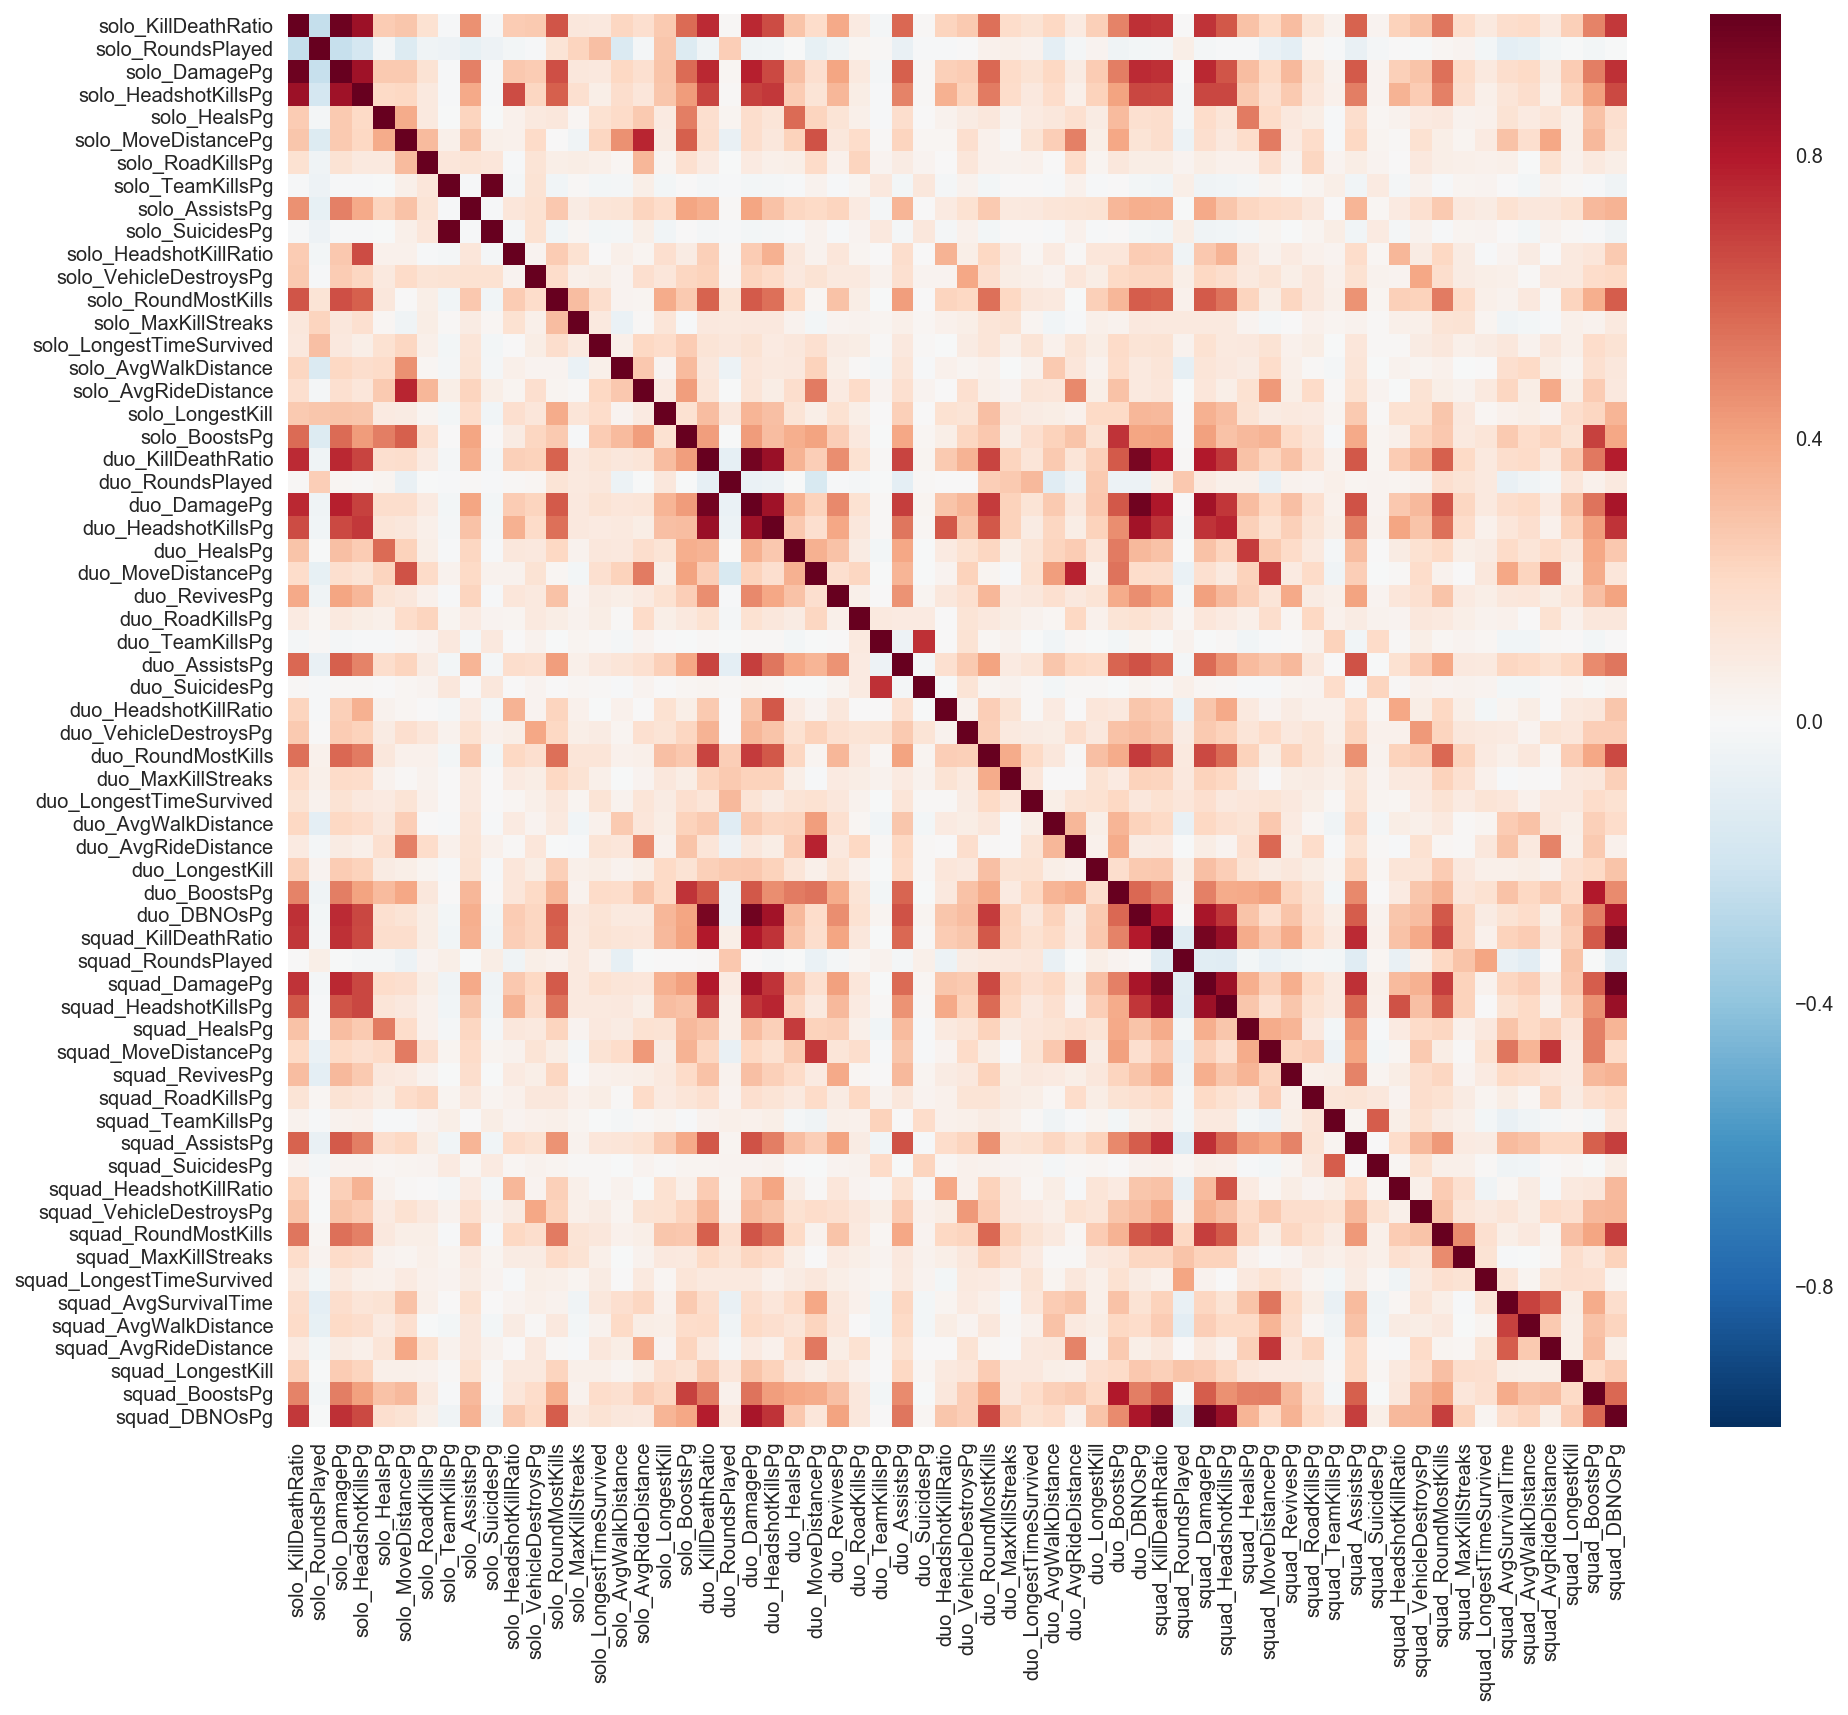

In [15]:
corr = pubg_df.corr()
plt.figure(figsize=(15,13))
sns.heatmap(corr)

위에서 간과한 부분인데, `AvgWalkDistance`와 `AvgRideDistance`, `MoveDistancePg`가 크면 당연히 생존 시간이 길어질 수 밖에 없다. 본 분석에서 보고자 하는 것과 거리가 멀다. 따라서 위 두 변수를 제거하고 대신 `RideWalkRatio` 변수를 만들어준다. 게임 타입 모두에 대해서 같은 작업을 해주도록 하자.

In [16]:
pubg_df = pubg_df.assign(solo_RideWalkRatio = pubg_df.solo_AvgRideDistance / pubg_df.solo_AvgWalkDistance)
pubg_df = pubg_df.assign(duo_RideWalkRatio = pubg_df.duo_AvgRideDistance / pubg_df.duo_AvgWalkDistance)
pubg_df = pubg_df.assign(squad_RideWalkRatio = pubg_df.squad_AvgRideDistance / pubg_df.squad_AvgWalkDistance)
pubg_df.drop(['solo_AvgRideDistance', 'solo_AvgWalkDistance', 'solo_MoveDistancePg',
             'duo_AvgRideDistance', 'duo_AvgWalkDistance', 'duo_MoveDistancePg',
             'squad_AvgRideDistance', 'squad_AvgWalkDistance', 'squad_MoveDistancePg'],
             axis=1, inplace=True)

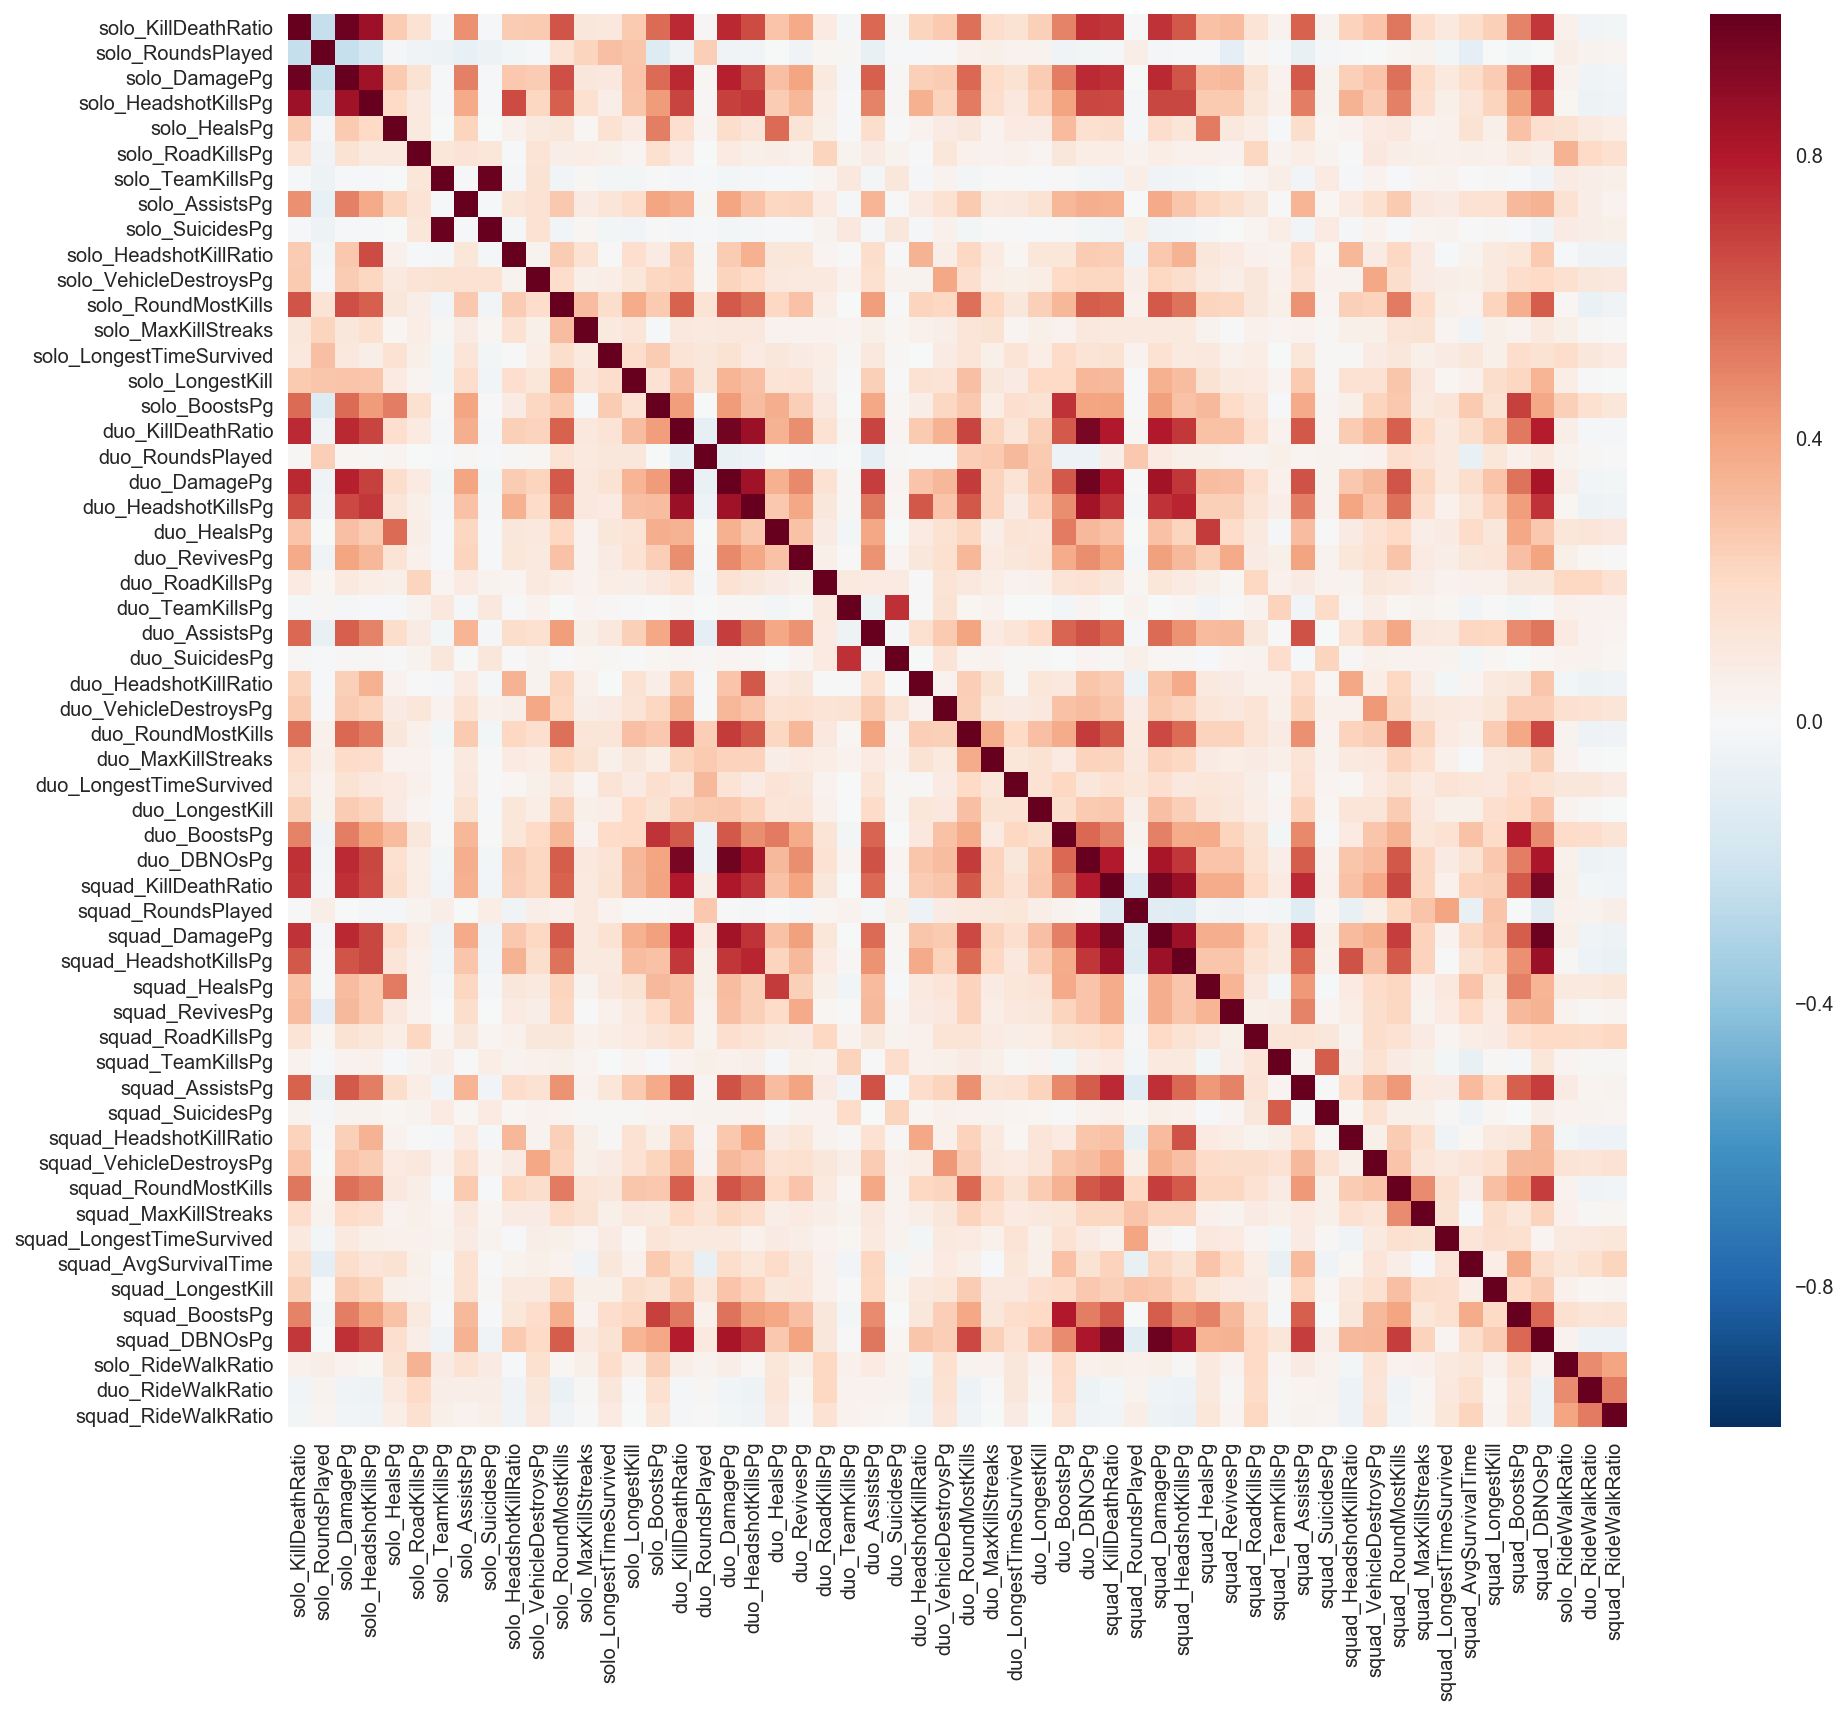

In [17]:
corr = pubg_df.corr()
plt.figure(figsize=(15,13))
sns.heatmap(corr)

변수 선택 작업을 끝낸 후 최종적인 입력 변수의 개수는 55개다.

In [18]:
variables = pubg_df.columns.tolist()
variables.remove('squad_AvgSurvivalTime')
print("The number of variables after removing the target:", len(variables))

The number of variables after removing the target: 55


각 입력변수의 분포를 살펴본다. 게임과 관련된 데이터의 경우 대부분 왜도(skewness)가 높은 경우가 많기 때문에 반드시 살펴보아야 한다. 왜도가 심한 경우는 로그를 취해 전처리하는 경우가 많다. 하지만 단지 경험적(heuristic)으로 좋은 성능을 얻은 것일 뿐, 반드시 좋지는 않다. 일반적으로 왜도의 절댓값이 2보다 큰 경우를 왜도가 크다고 말한다. [1]

[1] Gravetter, F., & Wallnau, L. (2014). Essentials of statistics for the behavioral sciences (8th ed.). Belmont, CA: Wadsworth.

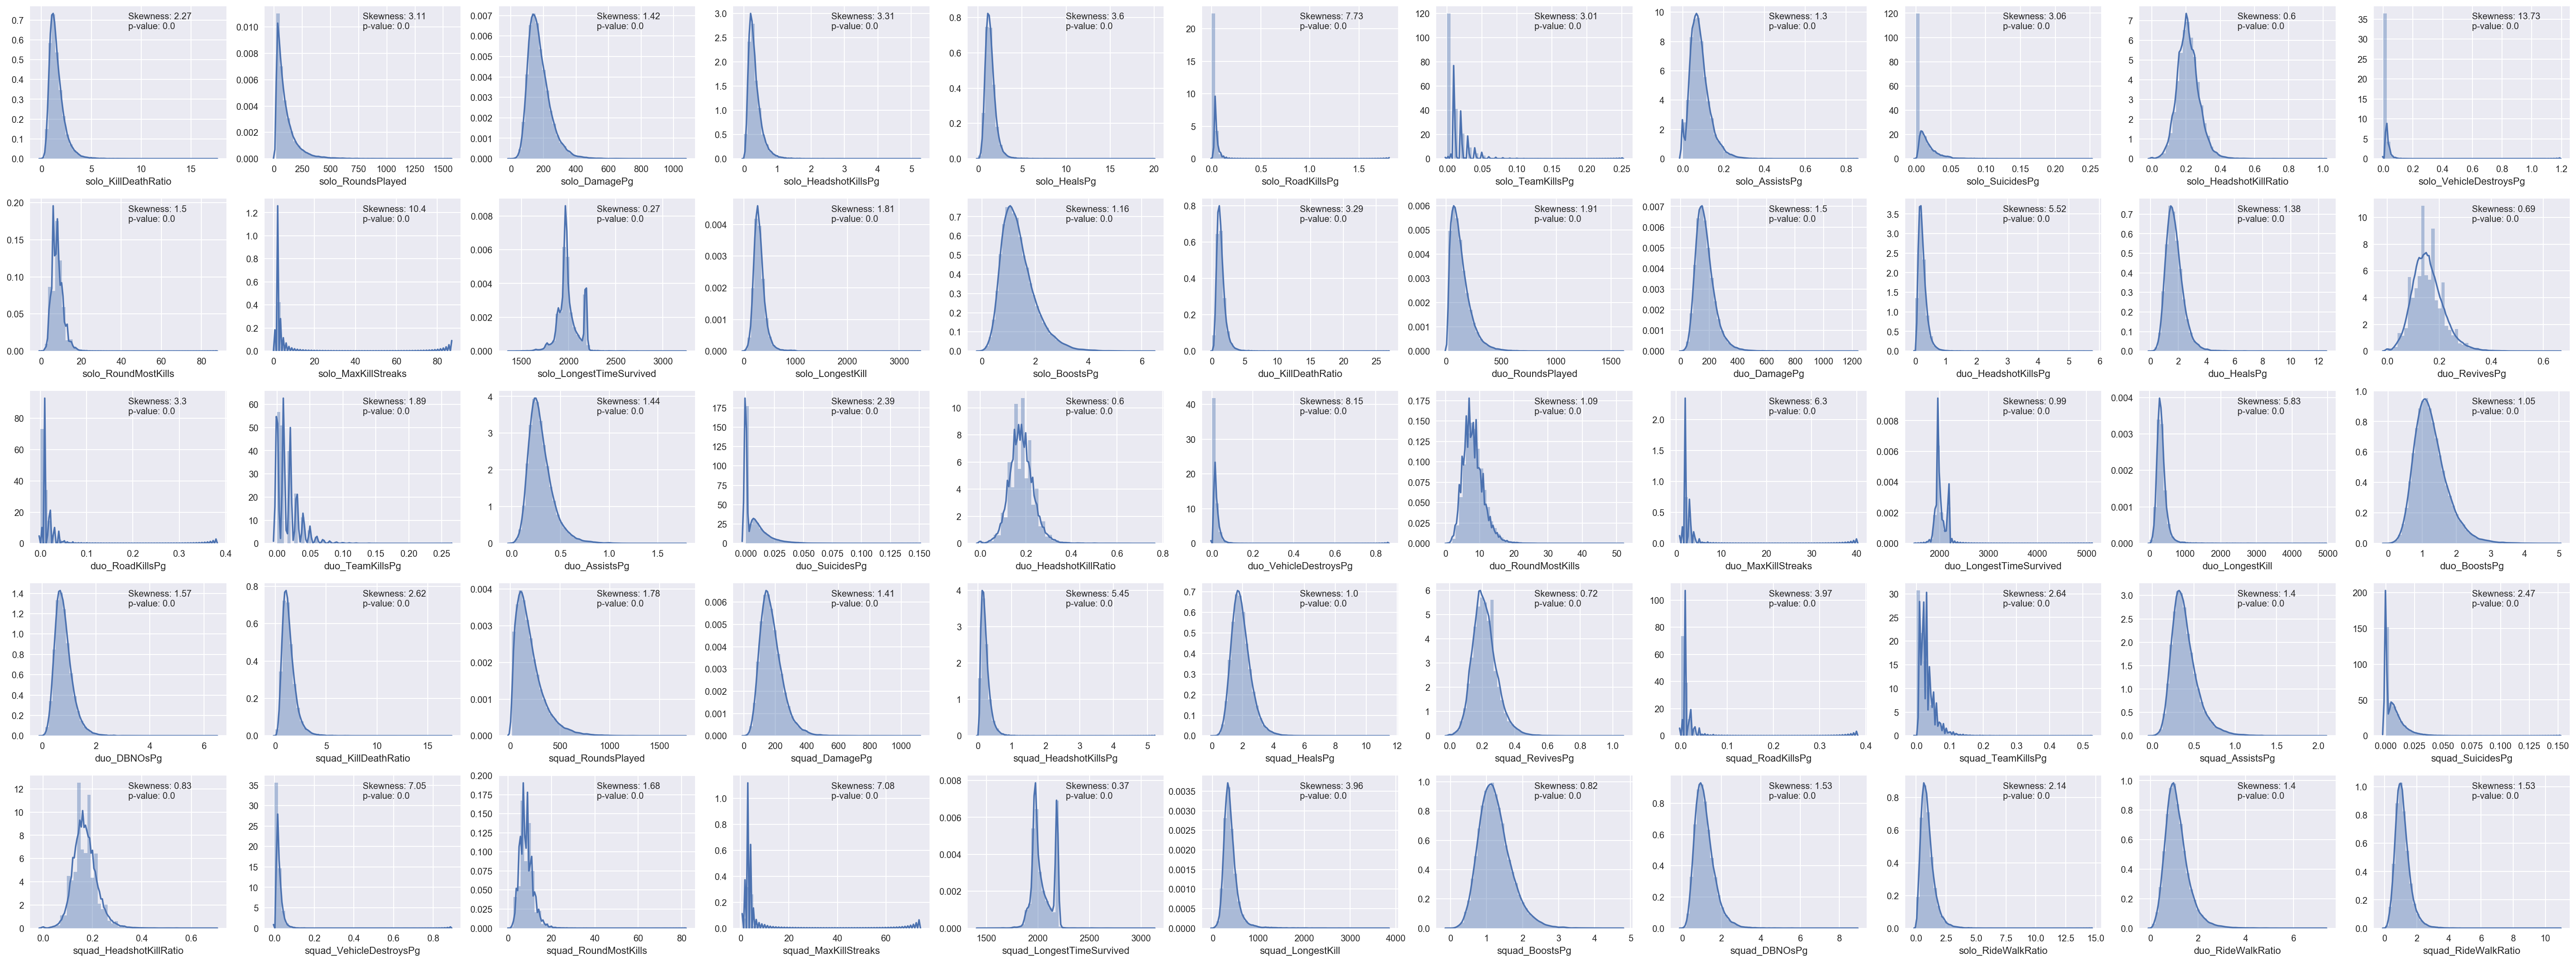

In [19]:
num_rows, num_columns = 11, 5
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40), sharex=False)
for i in range(num_rows):
    for j in range(num_columns):
        idx = i*num_columns+j
        if idx > len(variables) :
            break
        else :
            sns.distplot(pubg_df[variables[idx]], ax=axes[i, j])
            skewness = np.round(sp.stats.skew(pubg_df[variables[idx]]), 2)
            pvalue = np.round(sp.stats.skewtest(pubg_df[variables[idx]]).pvalue, 2)
            x = np.mean(axes[i, j].get_xlim())
            y = 0.85 * axes[i, j].get_ylim()[1]
            axes[i, j].text(x, y, "Skewness: {}\np-value: {}".format(skewness, pvalue))

plt.tight_layout()

예상대로 대부분의 변수에서 왜도가 2를 넘는 결과가 나타났다. 왜도가 2가 넘는 변수들은 로그를 취해서 전처리하는데, 음수의 결괏값을 방지하기 위해 `np.log1p` 함수를 사용한다.

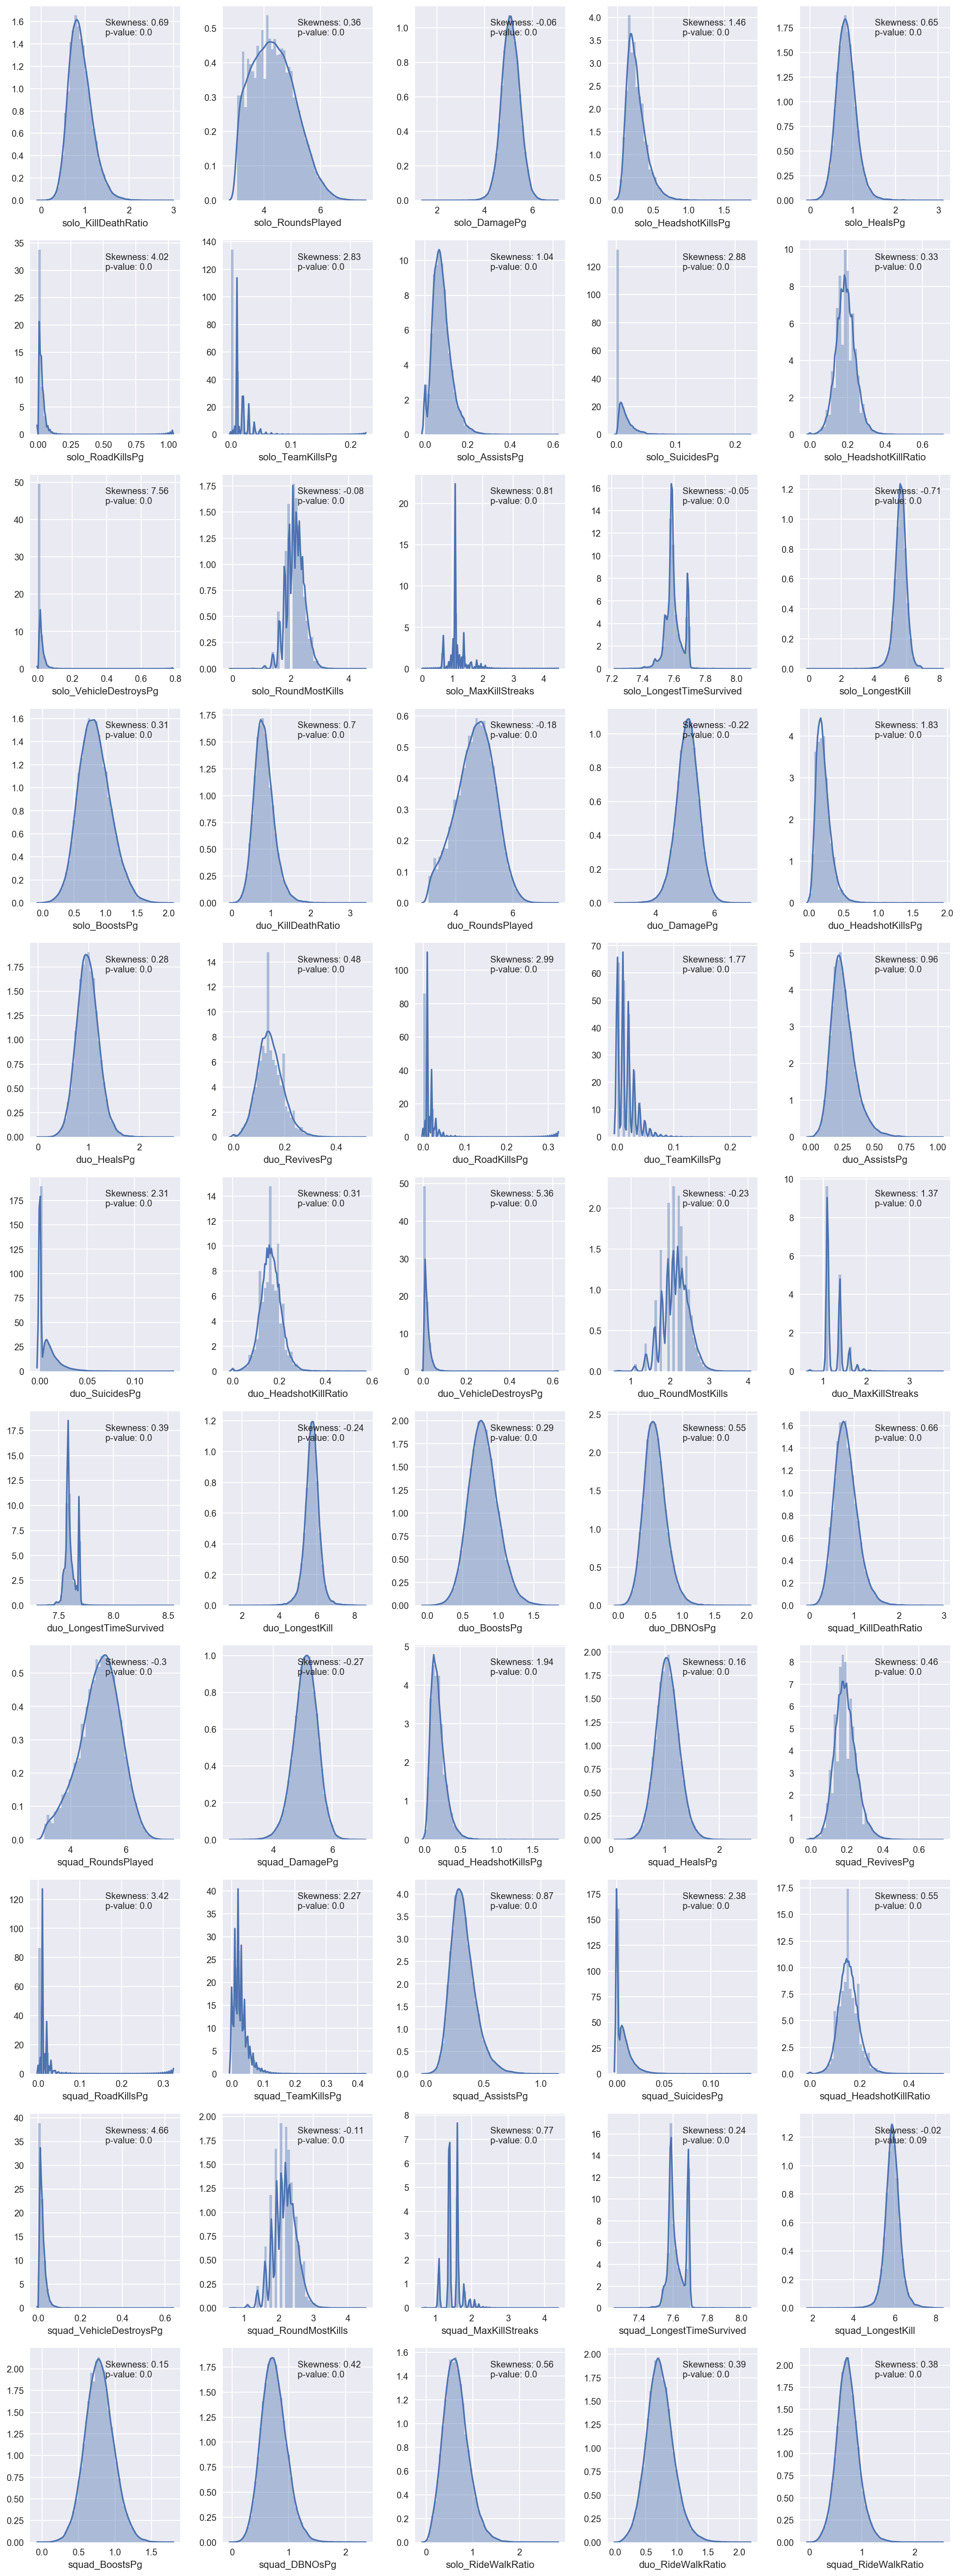

In [17]:
num_rows, num_columns = 11, 5
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40), sharex=False)
for i in range(num_rows):
    for j in range(num_columns):
        idx = i*num_columns+j
        if idx > len(variables) :
            break
        else :
            sns.distplot(np.log(pubg_df[variables[idx]]+1), ax=axes[i, j])
            skewness = np.round(sp.stats.skew(np.log1p(pubg_df[variables[idx]])), 2)
            pvalue = np.round(sp.stats.skewtest(np.log1p(pubg_df[variables[idx]])).pvalue, 2)
            x = np.mean(axes[i, j].get_xlim())
            y = 0.85 * axes[i, j].get_ylim()[1]
            axes[i, j].text(x, y, "Skewness: {}\np-value: {}".format(skewness, pvalue))

plt.tight_layout()

### Prediction task

예측 모델링은 다양한 알고리즘을 사용하여 진행하고 성능을 비교할 것이다. 또한 설명력을 위해 최소제곱법, 능형회귀, 엘라스틱넷 회귀, 랜덤 포레스트, 그라디언트 부스팅을 사용한다. 평가 메트릭으론 RMSE와 R2를 사용한다. 모든 알고리즘에서 능형회귀, 엘라스틱넷 회귀, 랜덤 포레스트에 사용되는 각 파라미터들은 모두 5-fold cv 를 이용하여 튜닝하며, 그라디언트 부스팅은 hold-out 데이터와 early stopping을 이용해 validation을 진행한다.

In [48]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
import xgboost as xgb

def rmse(predictions, targets):
    return np.round(np.sqrt(((predictions - targets) ** 2).mean()), 3)

X = pubg_df[variables]
y = pubg_df['squad_AvgSurvivalTime']

for var in X.columns :
    if sp.stats.skew(X[var]) > 2 :
        X[var] = np.log1p(X[var])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#### Linear regression

In [49]:
regr_ols = sm.OLS(y_train, X_train, hasconst=1).fit()
pred_ols = regr_ols.predict(X_test)
print("RMSE (OLS):", rmse(pred_ols, y_test))
print(regr_ols.summary())

RMSE (OLS): 155.089
                              OLS Regression Results                             
Dep. Variable:     squad_AvgSurvivalTime   R-squared:                       0.259
Model:                               OLS   Adj. R-squared:                  0.257
Method:                    Least Squares   F-statistic:                     185.6
Date:                   Thu, 15 Feb 2018   Prob (F-statistic):               0.00
Time:                           14:54:58   Log-Likelihood:            -1.8619e+05
No. Observations:                  28796   AIC:                         3.725e+05
Df Residuals:                      28741   BIC:                         3.730e+05
Df Model:                             54                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [50]:
coef_ols = pd.DataFrame(data={'Variable':regr_ols.params.index.tolist(), 'Weight':regr_ols.params.values})
coef_ols = coef_ols.sort_values(ascending=False, by=['Weight'])

In [51]:
def coef_plot(df, title, num=15, width=14, height=10, xlab='Weight'):
    top10 = df[:num] ; top10.index = np.arange(0, num)
    lowest10 = df[-num:] ; lowest10.index = np.arange(num, num*2)
    coef = pd.concat([top10, lowest10])
    plt.figure(figsize=(width, height))
    ax = sns.barplot(x = coef.Weight, y = coef.Variable)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Variables')
    ax.set_title(title)
    plt.tight_layout()

일부 변수만 로그로 변환하였기 때문에 변수에 대한 각각의 가중치 크기엔 큰 의미가 없다. 하지만 중요한 변수에 대한 큰 그림은 알 수 있을 것으로 예상된다.

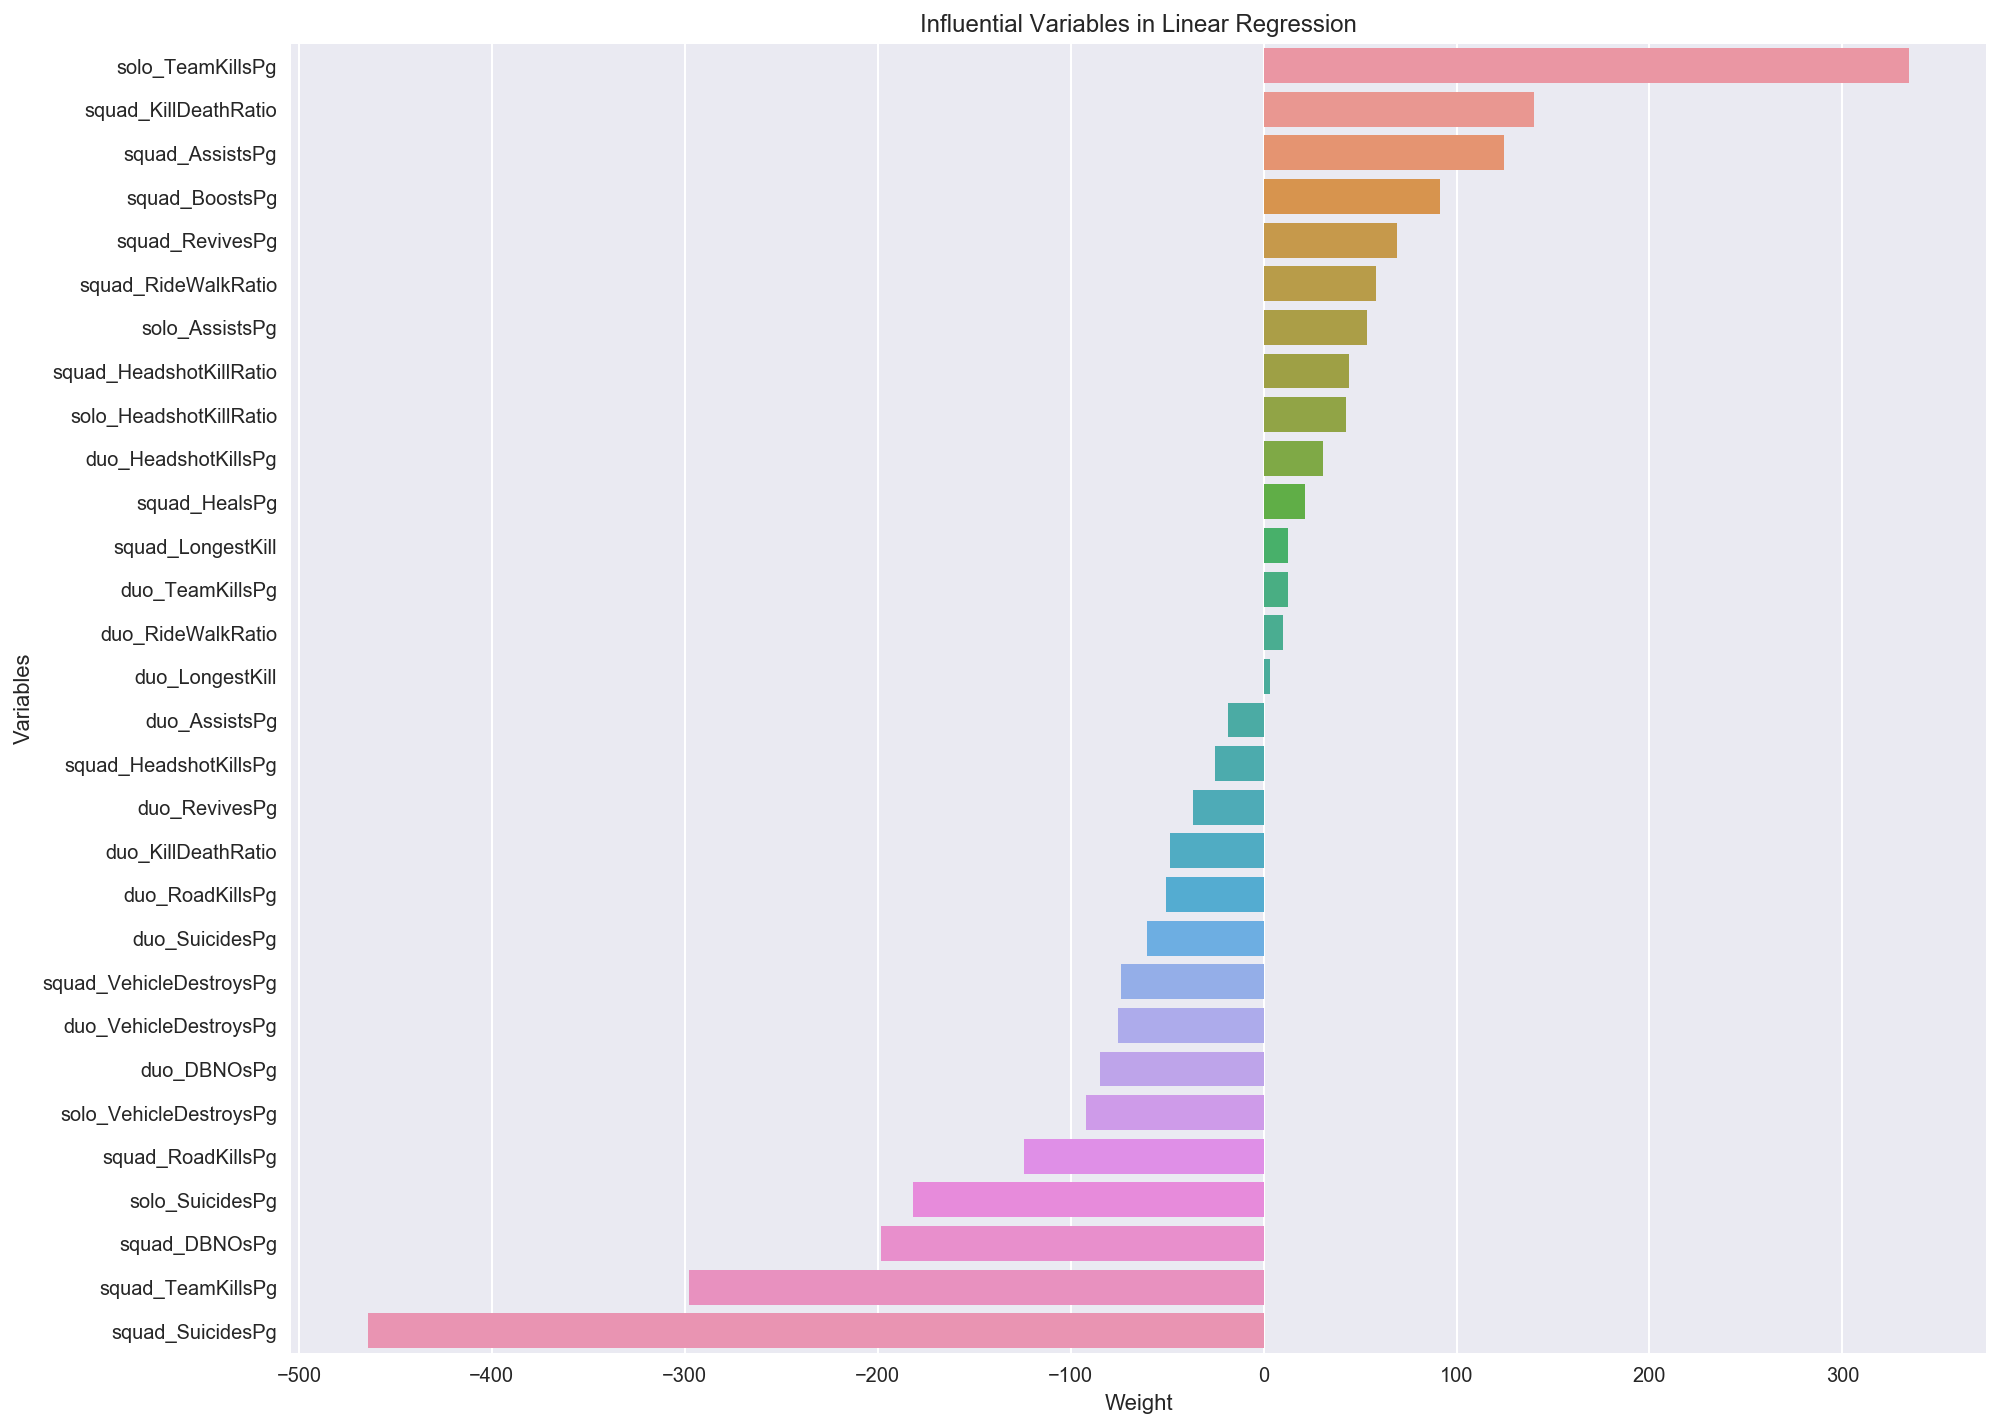

In [52]:
coef_plot(coef_ols, title='Influential Variables in Linear Regression')

#### Ridge regression

In [53]:
alphas = np.exp(np.linspace(0, 3, 100))
regr_ridge = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
regr_ridge.fit(X_train, y_train)
print('Selected alpha:', np.round(regr_ridge.alpha_, 3))

pred_ridge = regr_ridge.predict(X_test)
print("RMSE (Ridge):", rmse(pred_ridge, y_test))

Selected alpha: 2.266
RMSE (Ridge): 154.993


In [54]:
coef_ridge = pd.DataFrame(data={'Variable':X_train.columns.tolist(),
                                'Weight':regr_ridge.coef_})
coef_ridge = coef_ridge.sort_values(ascending=False, by=['Weight'])

능형 회귀(Ridge regression)은 $L_2$ 페널티로 인해 가중치가 과하게 커지는 것을 방지하기 때문에 최소제곱법으로 얻은 가중치값의 범위보다는 다소 좁다.

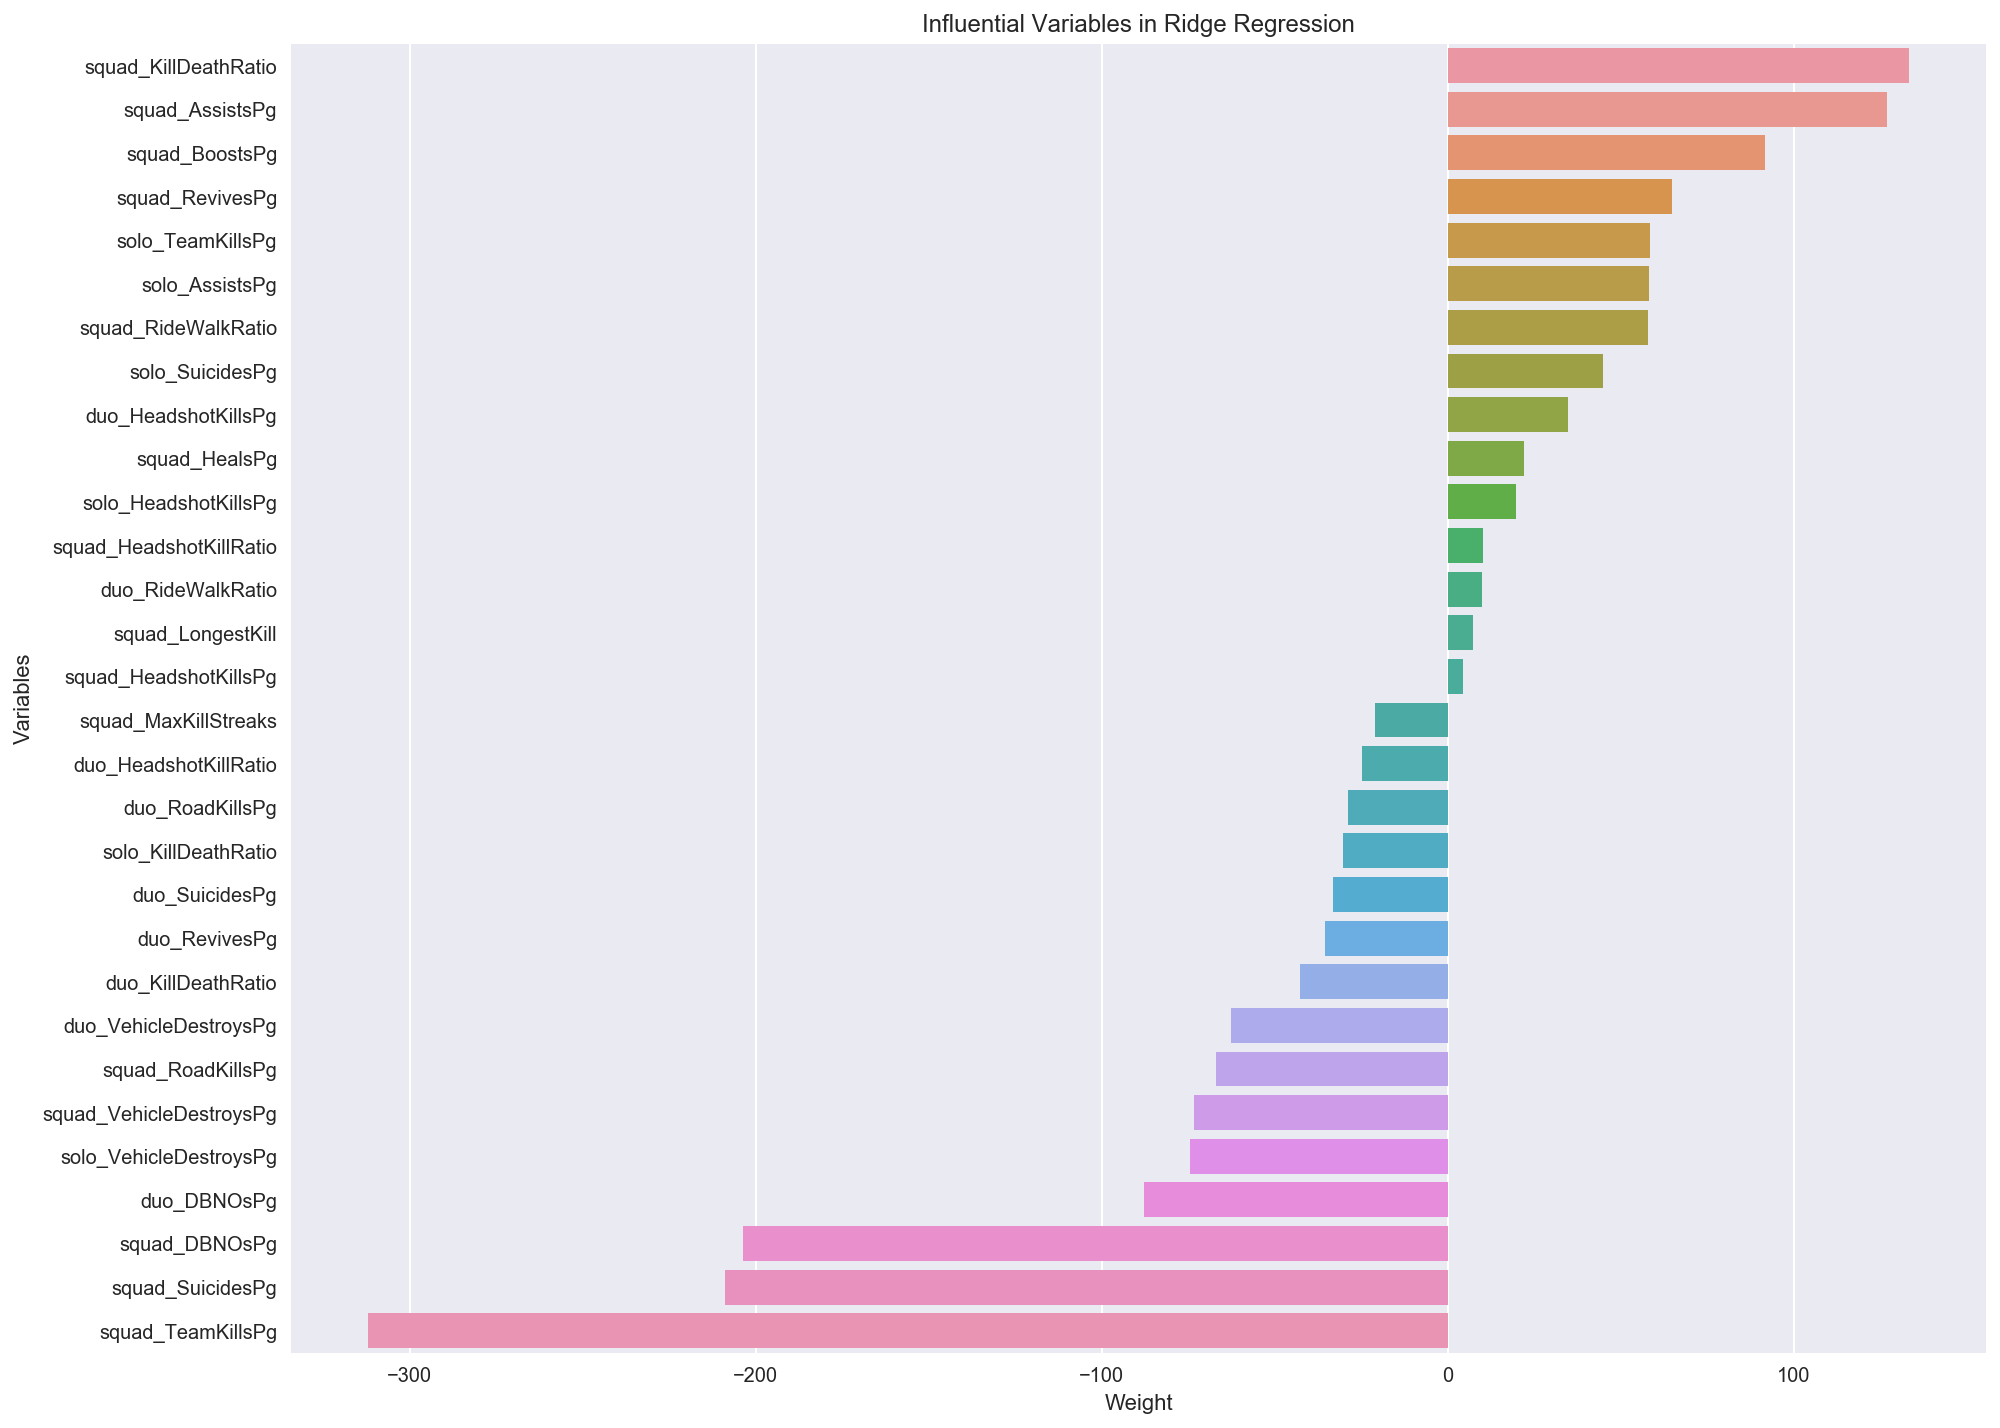

In [55]:
coef_plot(coef_ridge, title='Influential Variables in Ridge Regression')

#### Elastic Net

In [56]:
alphas_en = np.exp(np.linspace(-7, 0, 100))
l1_ratioes = np.linspace(0, 1, 10)
regr_elasticNet = ElasticNetCV(alphas=alphas_en, l1_ratio=l1_ratioes)
regr_elasticNet.fit(X_train, y_train)
print('Selected alpha:', np.round(regr_elasticNet.alpha_, 3), "/ L1 ratio:", regr_elasticNet.l1_ratio_)

pred_elasticNet = regr_elasticNet.predict(X_test)
print("RMSE (Elastic Net):", rmse(pred_elasticNet, y_test))

Selected alpha: 0.001 / L1 ratio: 0.888888888889
RMSE (Elastic Net): 154.997


위 결과에 따르면 $L_1$ 페널티의 비율이 매우 높아 거의 Lasso와 유사한 형태의 알고리즘이 되었다.

In [57]:
coef_elasticNet = pd.DataFrame(data={'Variable':X_train.columns.tolist(),
                                     'Weight':regr_elasticNet.coef_})
coef_elasticNet = coef_elasticNet.sort_values(ascending=False, by=['Weight'])

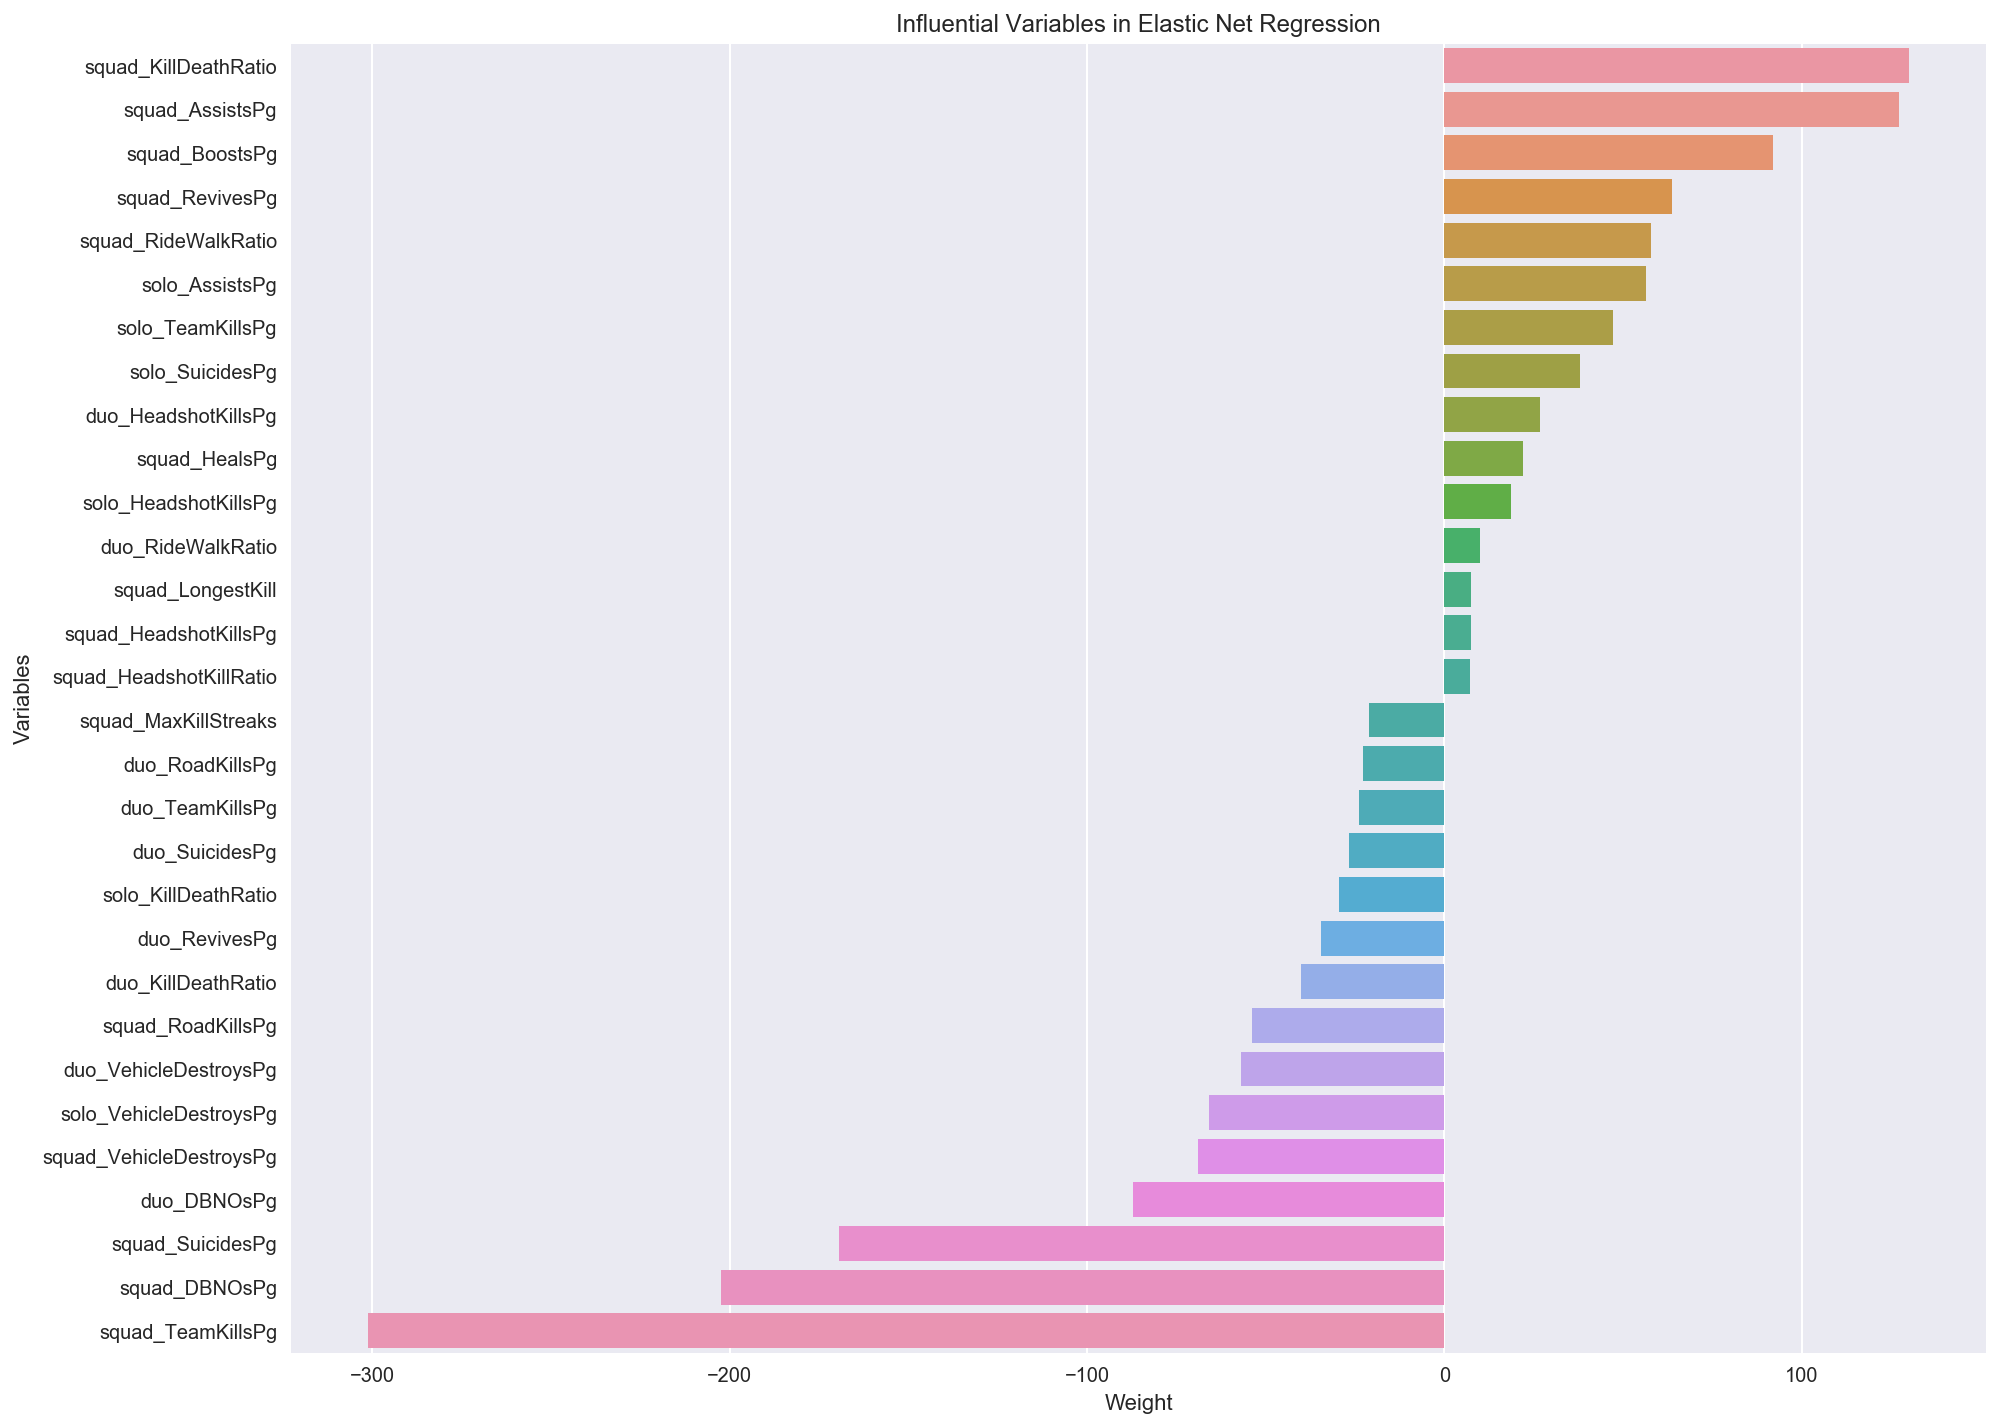

In [58]:
coef_plot(coef_elasticNet, title='Influential Variables in Elastic Net Regression')

위 세 모델에 따르면 생존과 관련된 변수들이 플러스 요인이 됨을 알 수 있다. 어시스트와 에너지드링크 등의 부스팅이 생존 시간을 크게 늘려주는 변수임을 알 수 있다. 걷는 시간보다 차량을 이용한 시간이 긴 경우 역시 생존 시간을 크게 늘려줌을 알 수 있다. 추가적으로 헤드샷 비율이 높은 경우 역시 생존 시간에 도움이 됐다. 반대로 팀킬이나 DBNO(Down But Not Out)가 많은 경우는 생존 시간을 줄이는 것으로 확인됐다. 따라서 게임에서 생존을 위한 전략으로는 기절한 적을 방치하지 않고 바로 사살하는 것이 중요함을 알 수 있다. 또한 에너지 드링크나 진통제 등을 소지할 경우 필요한 상황에 즉각적으로 사용하는 것이 매우 중요함을 알 수 있다.

#### Random Forest

In [29]:
param_grid_rf = {
    'max_depth': [11, 12, 13]
}

regr_rf = RandomForestRegressor(n_estimators=500, max_features='auto', n_jobs=-1, random_state=0)

In [30]:
grid_rf = GridSearchCV(regr_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train, y_train)
regr_rf_best = grid_rf.best_estimator_
pred_rf = regr_rf_best.predict(X_test)
print("RMSE (Random Forest):", rmse(pred_rf, y_test))

RMSE (Random Forest): 157.055


In [31]:
imp = regr_rf_best.feature_importances_
names = variables
imp, names = zip(*sorted(zip(imp, names)))

d = {'Variable': names, 'Importance': imp}
rf_feature_imp = pd.DataFrame(data=d)

In [32]:
rf_feature_imp = rf_feature_imp.sort_values(ascending=False, by=['Importance'])
rf_feature_imp.columns = ['Weight', 'Variable']

In [33]:
def coef_plot_tree(df, title, num=30, width=14, height=10, xlab='Feature Importance'):
    coef = df[:num] ; coef.index = np.arange(0, num)
    plt.figure(figsize=(width, height))
    ax = sns.barplot(x = coef.Weight, y = coef.Variable)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Variables')
    ax.set_title(title)
    plt.tight_layout()

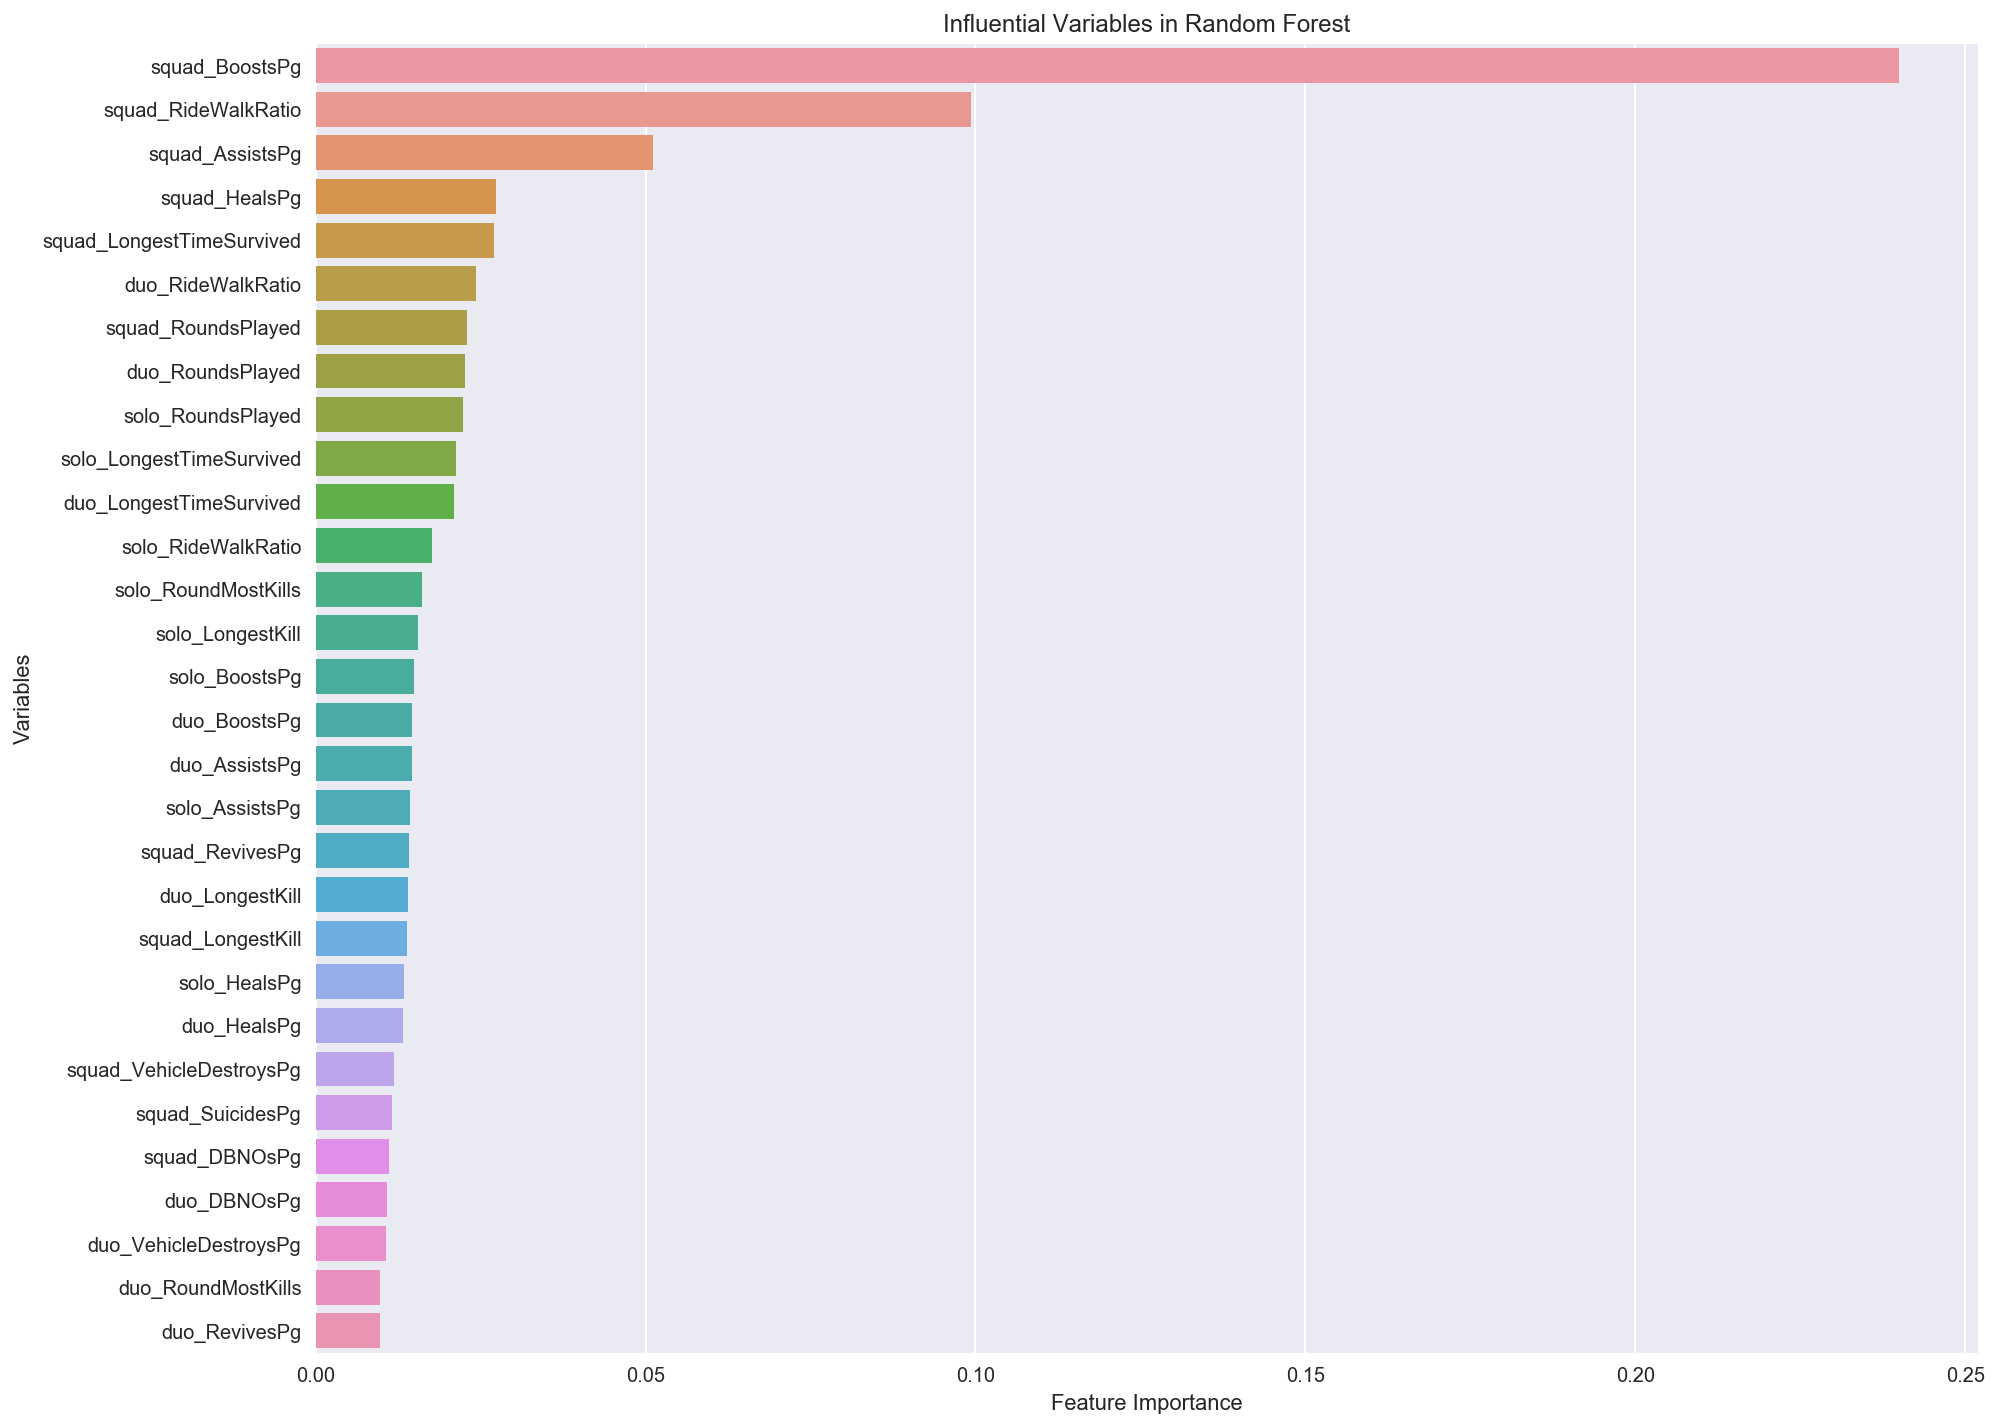

In [34]:
coef_plot_tree(rf_feature_imp, title='Influential Variables in Random Forest')

#### XGBoost

In [59]:
Xtr, Xv, ytr, yv = train_test_split(X_train, y_train, test_size=.2, shuffle=True, random_state=0)
xtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=X_train.columns)
xvalid = xgb.DMatrix(Xv, label=yv, feature_names=X_train.columns)
xtest  = xgb.DMatrix(X_test, feature_names=X_test.columns)

watchlist = [(xtrain, 'train'), (xvalid, 'valid')]

In [60]:
params_xgb = {
    'objective'         : 'reg:linear',
    'eta'               : 0.03,
    'max_depth'         : 4,
    'subsample'         : 0.6,
    'colsample_bylevel' : 0.75,
    'min_child_weight'  : 3,
    'n_jobs'            : -1
}

In [61]:
regr_xgb = xgb.sklearn.train(params_xgb,
                             xtrain,
                             num_boost_round = 1000,
                             evals=watchlist,
                             verbose_eval=50,
                             early_stopping_rounds=25)

[0]	train-rmse:1013.23	valid-rmse:1017.25
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 25 rounds.
[50]	train-rmse:269.93	valid-rmse:275.614
[100]	train-rmse:161.019	valid-rmse:169.666
[150]	train-rmse:151.144	valid-rmse:161.261
[200]	train-rmse:148.727	valid-rmse:160.063
[250]	train-rmse:147.034	valid-rmse:159.617
[300]	train-rmse:145.683	valid-rmse:159.449
[350]	train-rmse:144.379	valid-rmse:159.325
[400]	train-rmse:143.282	valid-rmse:159.251
[450]	train-rmse:142.194	valid-rmse:159.123
[500]	train-rmse:141.123	valid-rmse:158.994
[550]	train-rmse:140.131	valid-rmse:158.988
Stopping. Best iteration:
[531]	train-rmse:140.553	valid-rmse:158.941



In [62]:
pred_xgb = regr_xgb.predict(xtest)
print("RMSE (XGBoost):", rmse(pred_xgb, y_test))

RMSE (XGBoost): 154.185


In [63]:
xgb_feature_imp = pd.DataFrame({'Variable': list(regr_xgb.get_fscore().keys()),
                                'Weight'  : list(regr_xgb.get_fscore().values())})
xgb_feature_imp = xgb_feature_imp.sort_values(ascending=False, by=['Weight'])

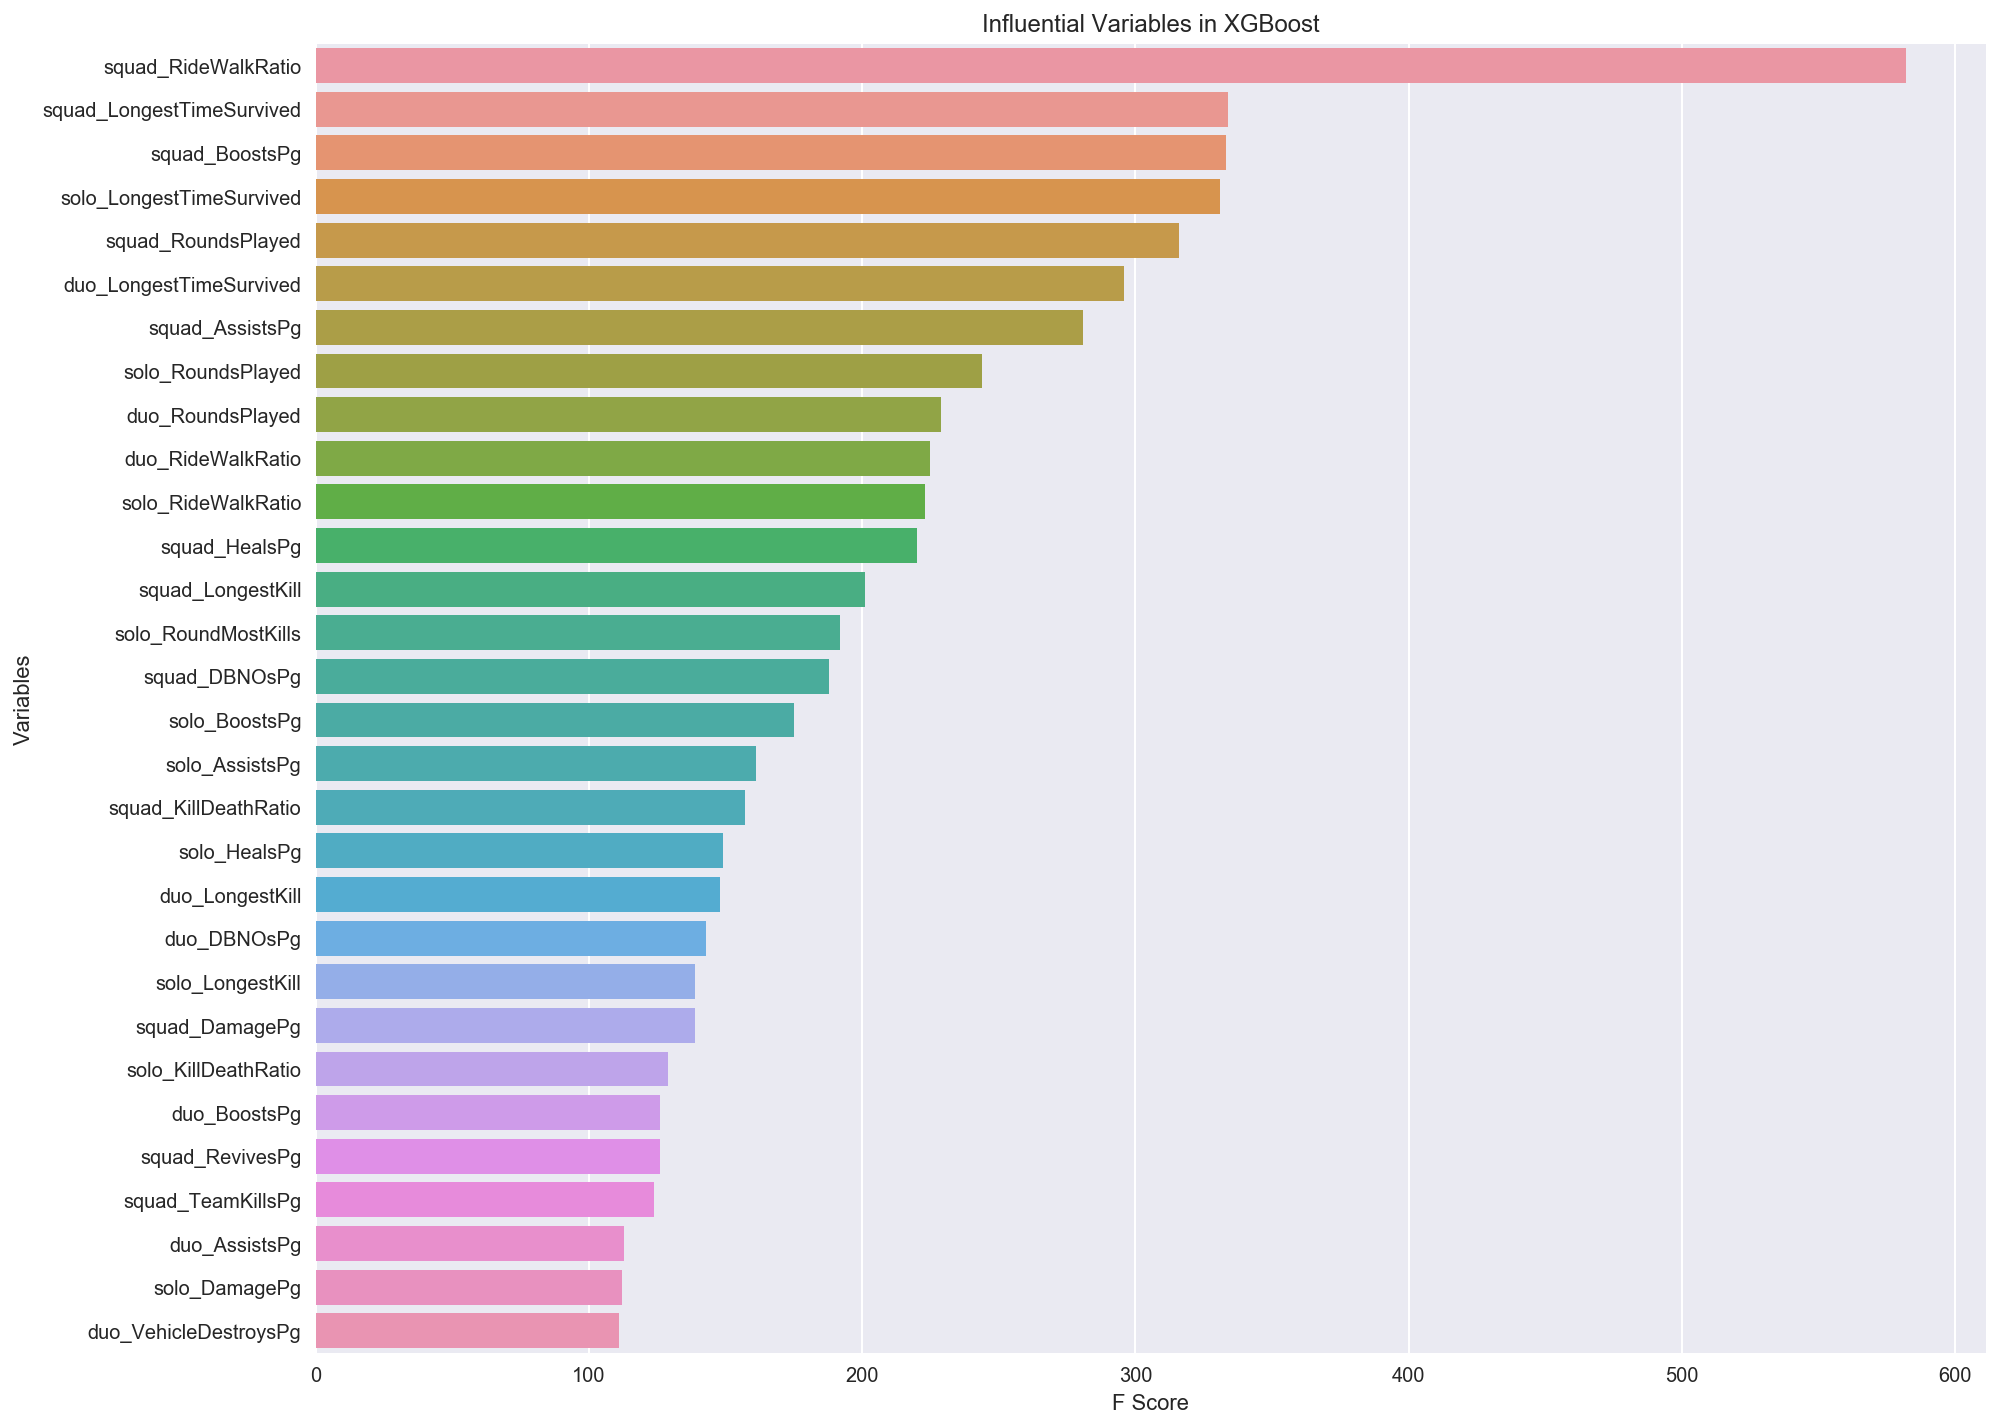

In [64]:
coef_plot_tree(xgb_feature_imp, title='Influential Variables in XGBoost', xlab="F Score")

**F Score**는 트리가 확장될 때 인스턴스들이 나뉘는 과정에서 특정 변수가 얼마나 사용되었는지를 나타낸다. 따라서 F Score가 높은 경우, 모델링에 큰 영향을 미친 것으로 중요 변수로 생각할 수 있다. 다만 그 중요도가 긍정적인지, 부정적인지는 알 수 없다. 위 결과에 따르면 탑승/도보 비율, 부스팅, 경험, 어시스트 등이 가장 중요한 변수로 채택되었음을 알 수 있다. 중요도는 조금 다를 수 있지만, 위의 알고리즘들과 대부분 비슷한 결과를 보여준다.

### Summary

In [65]:
summary = pd.DataFrame({'Regressor' : ['Linear Regression', 'Ridge', 'Elastic Net', 'Random Forest', 'XGBoost'],
                        'RMSE' : [rmse(pred_ols, y_test),
                                  rmse(pred_ridge, y_test),
                                  rmse(pred_elasticNet, y_test),
                                  rmse(pred_rf, y_test),
                                  rmse(pred_xgb, y_test)],
                        'R2'  : [r2_score(y_test, pred_ols),
                                 r2_score(y_test, pred_ridge),
                                 r2_score(y_test, pred_elasticNet),
                                 r2_score(y_test, pred_rf),
                                 r2_score(y_test, pred_xgb)]})

예측력은 그라디언트 부스팅이 가장 좋았으며, 랜덤 포레스트가 가장 나쁜 성능을 보여주었다. 하지만 그라디언트 부스팅이 다른 회귀분석 알고리즘들과 큰 예측력의 차이를 보이지 않았으므로 상황에 따라 적절한 알고리즘을 사용하는 것이 좋을 것으로 보인다.

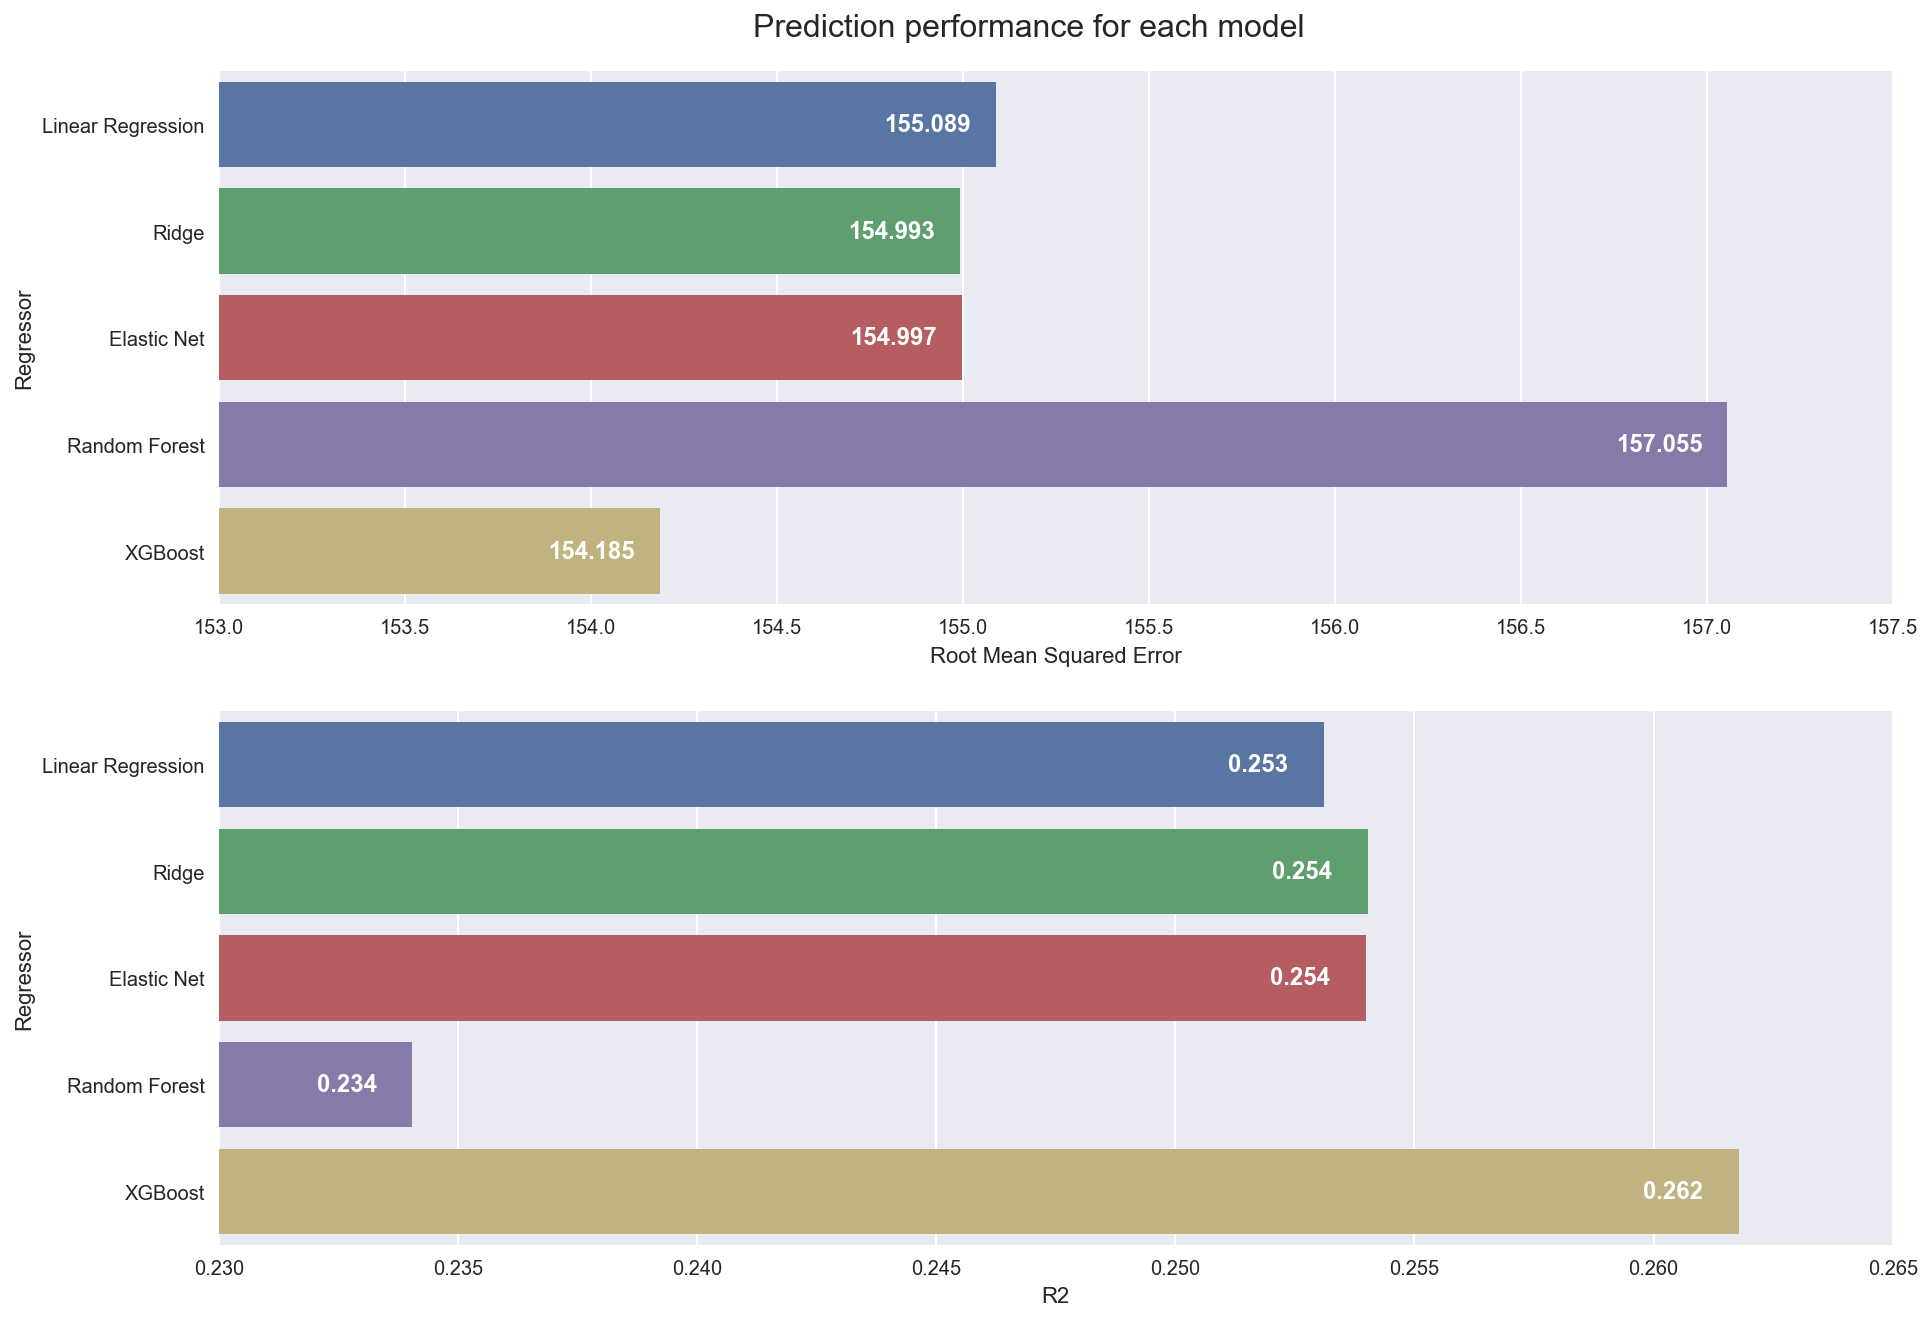

In [66]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
axes[0].set_xlim(153, 157.5)
axes[1].set_xlim(0.23, 0.265)
sns.barplot(x=summary['RMSE'], y=summary['Regressor'], ax=axes[0])
sns.barplot(x=summary['R2'], y=summary['Regressor'], ax=axes[1])
axes[0].set_xlabel('Root Mean Squared Error')
axes[1].set_xlabel('R2')
for i in range(len(summary)) :
    axes[0].text(summary['RMSE'][i]-0.3, i, summary['RMSE'][i],
                 verticalalignment='center', fontsize='large', color='w', weight='semibold')
    axes[1].text(summary['R2'][i]-0.002, i, np.round(summary['R2'][i], 3),
                 verticalalignment='center', fontsize='large', color='w', weight='semibold')
plt.suptitle("Prediction performance for each model", fontsize=16)
plt.subplots_adjust(top=0.94)

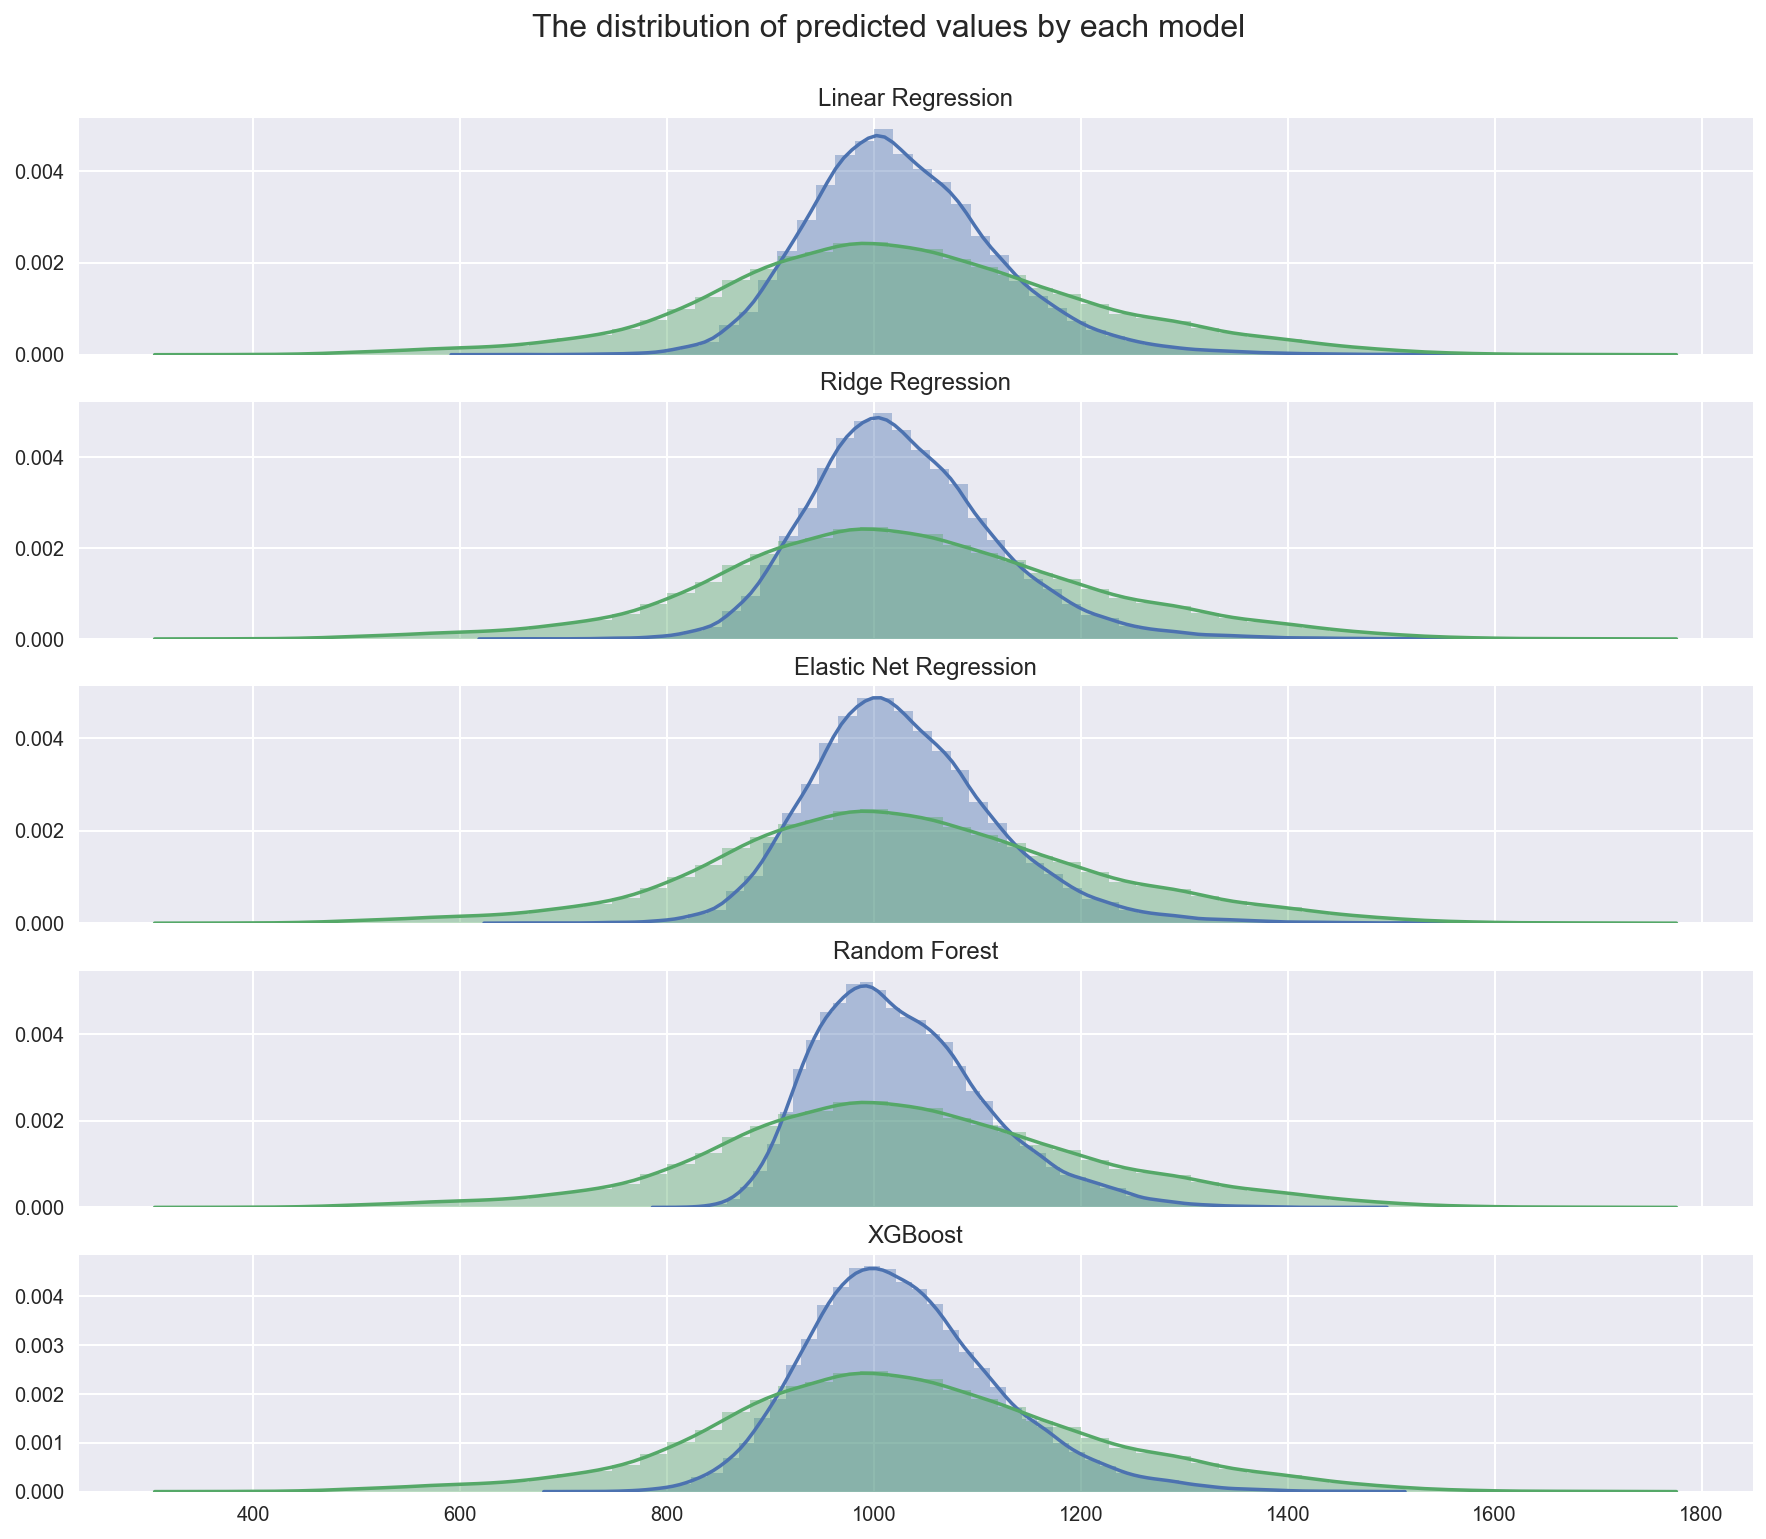

In [67]:
fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)
sns.distplot(pred_ols, ax=axes[0]) ; sns.distplot(y_test.values, ax=axes[0])
sns.distplot(pred_ridge, ax=axes[1]) ; sns.distplot(y_test.values, ax=axes[1])
sns.distplot(pred_elasticNet, ax=axes[2]) ; sns.distplot(y_test.values, ax=axes[2])
sns.distplot(pred_rf, ax=axes[3]) ; sns.distplot(y_test.values, ax=axes[3])
sns.distplot(pred_xgb, ax=axes[4]) ; sns.distplot(y_test.values, ax=axes[4])

axes[0].set_title('Linear Regression')
axes[1].set_title('Ridge Regression')
axes[2].set_title('Elastic Net Regression')
axes[3].set_title('Random Forest')
axes[4].set_title('XGBoost')
plt.suptitle("The distribution of predicted values by each model", fontsize=16)
plt.subplots_adjust(top=0.92)

위 히스토그램들은 실제 테스트 데이터의 생존시간 분포와 각 알고리즘을 통해 얻은 예측값의 분포를 보여준다. 예측된 값들은 실제 데이터보다 보다 좁은 폭에서 존재하는 것을 확인할 수 있으며, 각 알고리즘들의 예측값의 분포는 대체로 유사함을 알 수 있다. 특히 회귀분석 계열의 알고리즘들은 경향성마저 거의 유사함을 아래 pair plot으로 확인할 수 있다.

In [44]:
preds_wide = pd.DataFrame({'Linear Regression' : pred_ols,
                           'Ridge Regression' : pred_ridge,
                           'Elastic Net' : pred_elasticNet,
                           'Random Forest' : pred_rf,
                           'XGBoost' : pred_xgb})

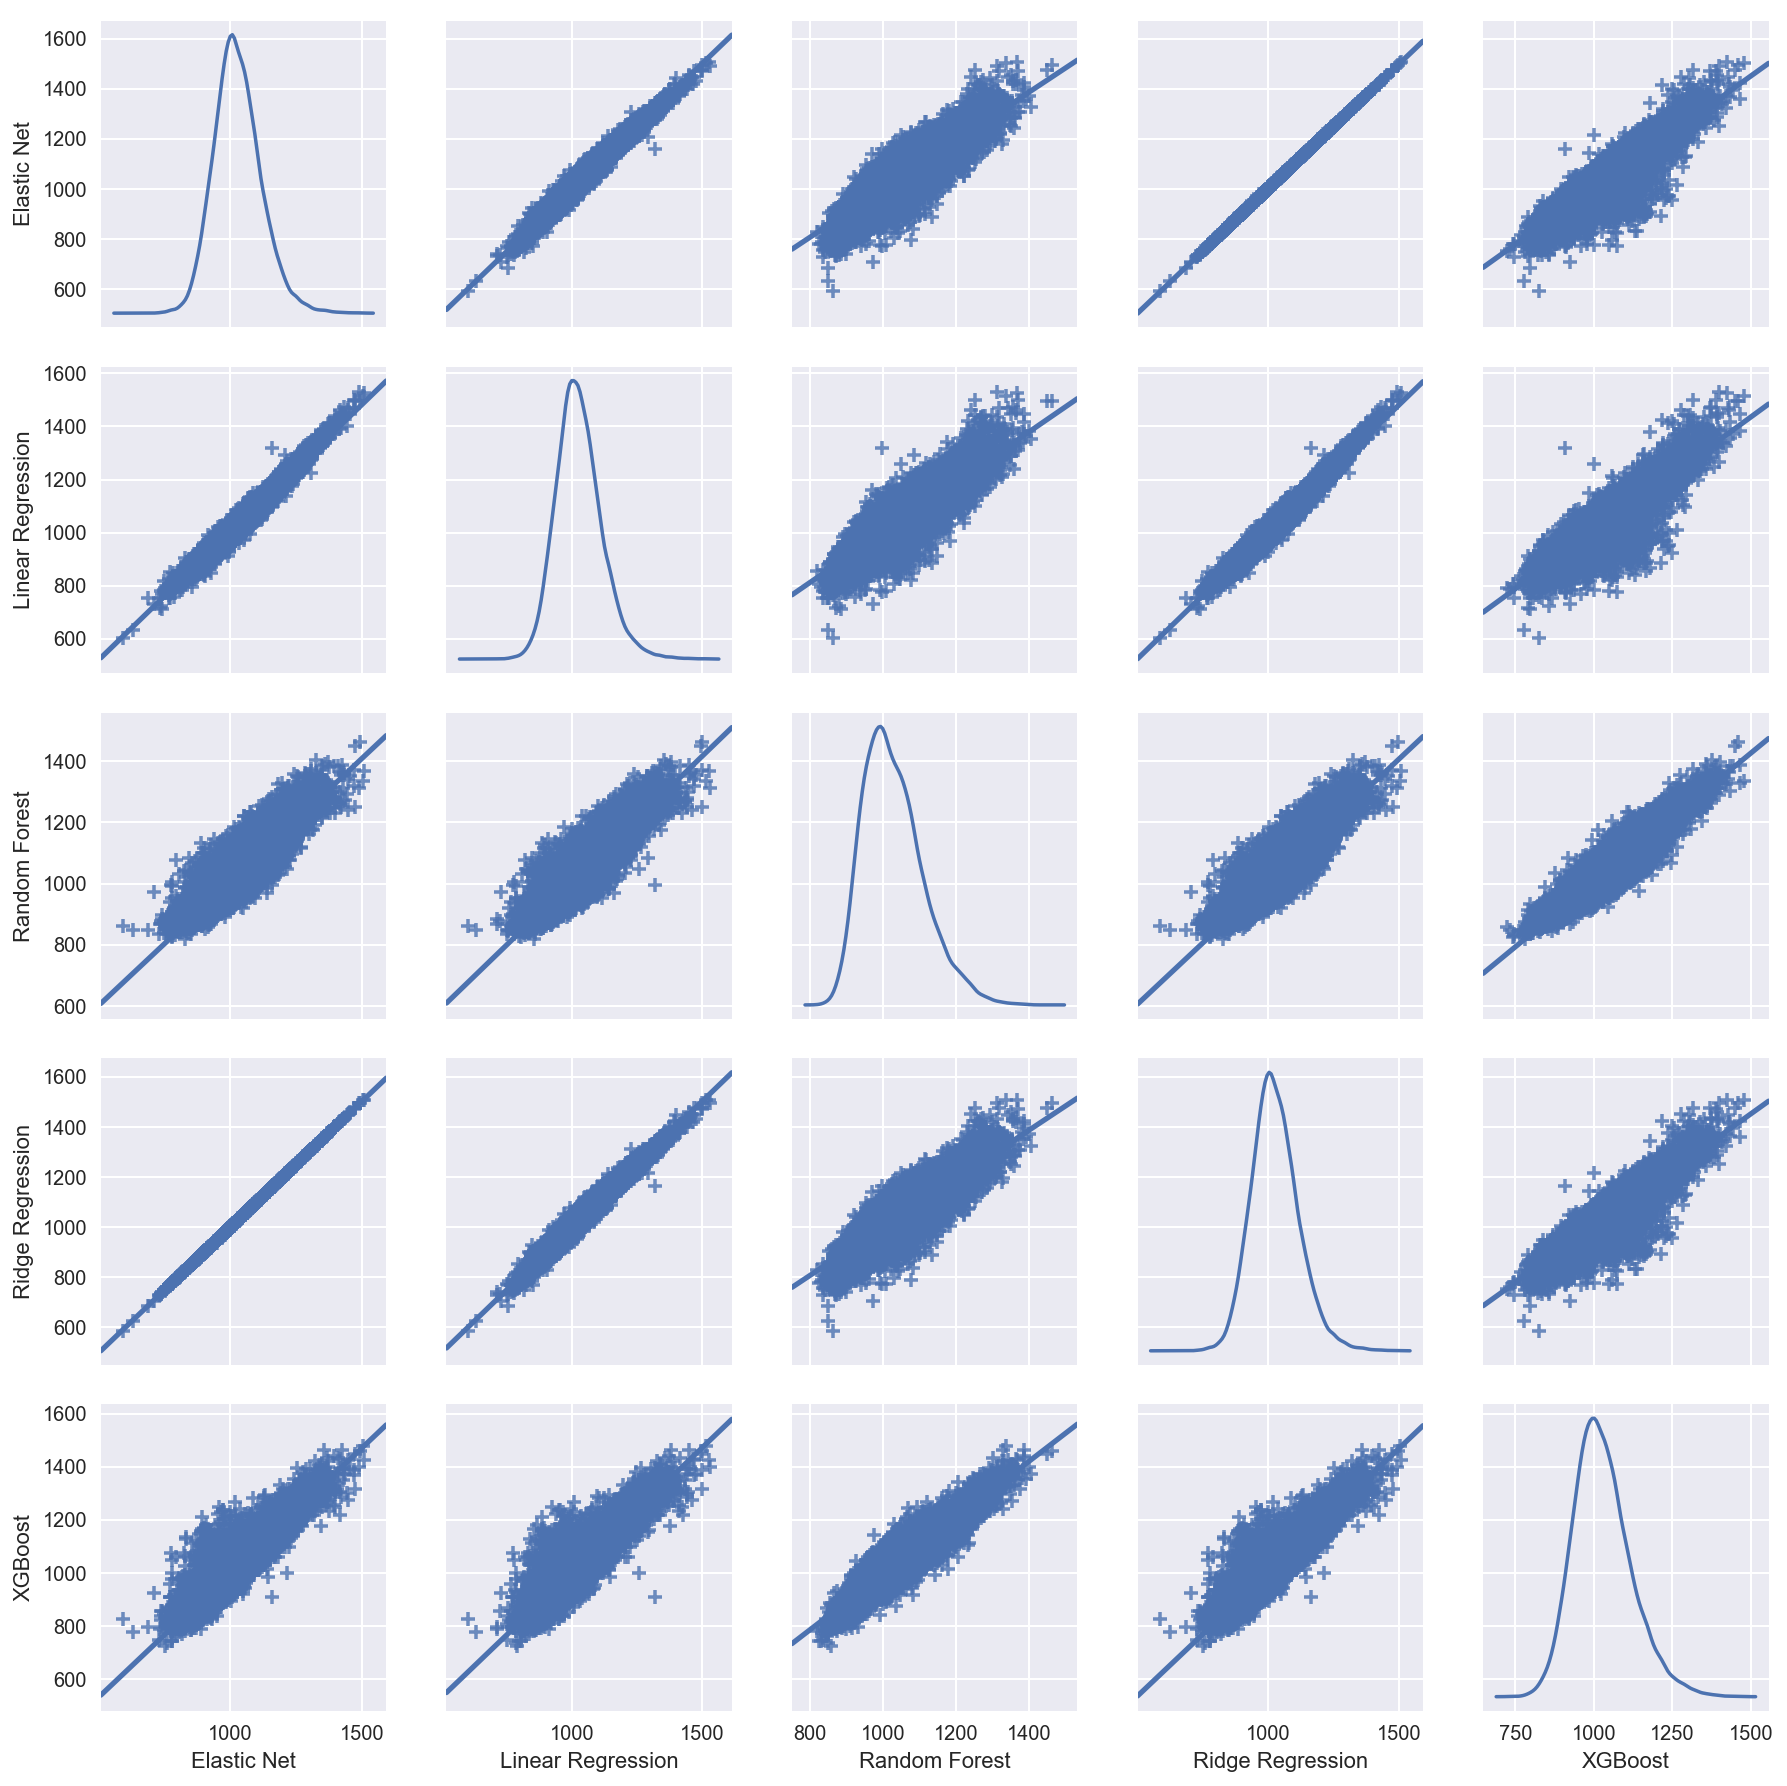

In [45]:
sns.pairplot(preds_wide, kind='reg', diag_kind='kde', markers='+')